In [1]:
cd ../

/home/hughes/usr/d_vae_hea


In [4]:
import argparse
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from torch.optim import Adam
from pyro.optim import ReduceLROnPlateau
from pyro.contrib.examples.util import print_and_log
import pyro.poutine as poutine
from utils.custom_mlp import MLP, Exp
import shap

In [5]:
import numpy as np
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.special import expit
import pdb
import plotly.graph_objects as go
import plotly.express as px
import pickle
from datetime import datetime


**Import composition and engineered data and merge them into a single dataframe**

In [8]:
data_directory = './data/'

hea_top30_data = pd.read_csv(data_directory + 'HEA_top30_comps.csv', comment='#')
hea_feature_engineered_df = pd.read_csv(data_directory + 'HEA_feature_engineered.csv')

hea_top30_data = hea_top30_data.drop_duplicates(subset='Alloys', keep='first')
hea_feature_engineered_df = hea_feature_engineered_df.drop_duplicates(subset='Alloys', keep='first')

merged_df = pd.merge(hea_top30_data, hea_feature_engineered_df.drop(columns='Class'), on='Alloys', how='inner')
merged_df.head()

Alloys  Class   Fe   Ni   Cr   Co   Al   Ti   Cu   Mo  ...   Li   Sc  \
0  Mg1Ni1      0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  Mg1Cu1      0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0  ...  0.0  0.0   
2  Fe1Mg1      0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  Cr1Mg1      0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4   Mg1V1      0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

       k      vm       tm  vac     delta  delta_chi  delta_s_mix  delta_h_mix  
0  112.0  10.300  1325.65  6.0  5.263158      0.300     5.762824         -8.0  
1   92.5  10.550  1140.46  6.5  5.263158      0.295     5.762824         -6.7  
2  107.0  10.550  1367.15  5.0  3.448276      0.260     5.762824         23.2  
3  102.5  10.615  1551.65  4.0  3.448276      0.175     5.762824         31.7  
4  102.0  11.175  1553.15  3.5  5.263158      0.160     5.762824         30.2  

[5 rows x 40 columns]

**Construct Dataset classes to load data**

In [9]:
### this class is for importing composition data, engineered data, and labels ###
class HEAFeatureDataset(Dataset): 
    def __init__(self, pd, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        labels = np.array(self.data.iloc[idx]["Class"], np.float32)
        data = np.array(self.data.iloc[idx]["Fe":"Sc"], np.float32)
        data_engineered = np.array(self.data.iloc[idx]["k":"delta_h_mix"], np.float32)
        if self.transform:
            data = self.transform(data)

        return torch.tensor(data * 100), torch.tensor(data_engineered), torch.tensor(labels).unsqueeze(-1)

### this class is for importing just composition data and engineered data, no labels###
class HEAFeatureDatasetUnlabelled(Dataset):
    def __init__(self, pd, transform=None):
        """
        Args:
            pd (DataFrame): pandas dataframe
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = np.array(self.data.iloc[idx]["Fe":"Sc"], np.float32)
        data_engineered = np.array(self.data.iloc[idx]["k":"delta_h_mix"], np.float32)
        if self.transform:
            data = self.transform(data)

        return torch.tensor(data * 100), torch.tensor(data_engineered)

**load train, test, val dataframes as used during training**

In [10]:
labelled_hea = pickle.load(open('./data/labelled_hea.pk', 'rb'))
unlabelled_hea = pickle.load(open('./data/unlabelled_hea.pk', 'rb'))
test_hea = pickle.load(open('./data/test_hea.pk', 'rb'))
validation_hea = pickle.load(open('./data/validation_hea.pk', 'rb'))

In [11]:
FEATURE_SIZE = 30
BATCH_SIZE = 32
DEFAULT_HIDDEN_DIMS = [100,100]
DEFAULT_Z_DIM = 2

In [12]:
print("Reading in dataset...")

hea_feature_dataset = HEAFeatureDataset(pd=labelled_hea)
hea_feature_loader = torch.utils.data.DataLoader(hea_feature_dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True,)

N_samples = len(hea_feature_dataset)
print("Number of labelled observations:", N_samples)

hea_feature_dataset_ul = HEAFeatureDataset(pd=unlabelled_hea)
hea_feature_loader_ul = torch.utils.data.DataLoader(hea_feature_dataset_ul,
                                                  batch_size=BATCH_SIZE, shuffle=True,)
N_samples = len(hea_feature_dataset_ul)
print("Number of unlabelled observations:", N_samples)

hea_feature_dataset_val = HEAFeatureDataset(pd=validation_hea)
hea_feature_loader_val = torch.utils.data.DataLoader(hea_feature_dataset_val,
                                                  batch_size=len(hea_feature_dataset_val), shuffle=True,)
N_samples = len(hea_feature_dataset_val)
print("Number of validation observations:", N_samples)

hea_feature_dataset_test = HEAFeatureDataset(pd=test_hea)
hea_feature_loader_test = torch.utils.data.DataLoader(hea_feature_dataset_test,
                                                  batch_size=BATCH_SIZE, shuffle=True,)
N_samples = len(hea_feature_dataset_test)
print("Number of test observations:", N_samples)

data_loaders = {"sup": hea_feature_loader , "unsup": hea_feature_loader_ul, "val": hea_feature_loader_val, "test": hea_feature_loader_test}
### "sup" is for supervised training data, "unsup" is for unsupervised training data, "val" is for validation, "test" is for test

Reading in dataset...
Number of labelled observations: 864
Number of unlabelled observations: 296
Number of validation observations: 75
Number of test observations: 138


**Define Model, this is the same as training**

In [13]:
class SSVAE(nn.Module):
    """
    The semi-supervised VAE

    :param output_size: size of the tensor representing the class label (1 for our data, as it's binary)
    :param input_size: size of the tensor representing the input (30 for our data)
    :param z_dim: size of the tensor representing the latent random variable z
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """

    def __init__(
        self,
        output_size=1,
        input_size=30,
        z_dim=2,
        hidden_layers=(500,),
        config_enum=None,
        use_cuda=False,
        aux_loss_multiplier=None,
    ):
        super().__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == "parallel"
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the parameters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):
        z_dim = self.z_dim
        hidden_sizes = self.hidden_layers

        # Encoder for y outputs a single probability per instance (Bernoulli parameter)
        self.encoder_y = MLP(
            [8] + hidden_sizes + [1],  # Output size is 1 for Bernoulli probability
            activation=nn.Softplus,
            output_activation=nn.Sigmoid,  # Sigmoid activation for a valid probability
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        # Encoder for z outputs parameters for a normal distribution
        # Final output size is [z_dim, z_dim] for mean and std dev, activations are None and Exp (for std)
        self.encoder_z = MLP(
            [self.input_size + 1] + hidden_sizes + [[z_dim, z_dim]],  # Added +1 for binary y
            activation=nn.Softplus,
            output_activation=[None, Exp],  # Exp to ensure positive standard deviation
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        # Decoder outputs probabilities for a multinomial distribution
        # Assuming the total number of categories in x is defined by input_size
        self.decoder = MLP(
            [z_dim + 1] + hidden_sizes + [self.input_size],  # Adjust input for binary y
            activation=nn.Softplus,
            output_activation=nn.Softmax(dim=-1),  # Softmax to create a probability distribution
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        if self.use_cuda:
            self.cuda()

    def model(self, xs, es=None, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # prior on latents
        p(y|x) = Bernoulli(1/2.)     # which phase (semi-supervised)
        p(x|y,z) = Multinomial(loc(y,z))   # output composition
        loc is given by a neural network  `decoder`

        :param xs: a batch of composition data
        :param ys: (optional) a batch of the class labels i.e.
                   phase corresponding to a given composition
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):
            # sample the latents from the constant prior distribution
            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which phase) is unsupervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            ys_prior_mean  = torch.ones(size=[batch_size, self.output_size]) *0.5
            if ys is None:
                ys = pyro.sample("y", dist.Bernoulli(probs=ys_prior_mean).to_event(1))
            else:
                ys = pyro.sample("y", dist.Bernoulli(probs=ys_prior_mean).to_event(1), obs=ys)

            # Finally, score the composition data (x) using the latent (z) and
            # the class label y (which phase) against the
            # parametrized distribution p(x|y,z) = Multinomial(decoder(y,z))
            # where `decoder` is a neural network.
            loc = self.decoder([zs, ys])
            pyro.sample("x", dist.Multinomial(total_count=101, probs=loc), obs=xs)
            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, es=None, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = Bernoulli(probs(f(x)))              # infer phase from engineered features for composition x
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer latents from composition and the phase
        loc, scale are given by a neural network `encoder_z`
        probs is given by a neural network `encoder_y`

        :param xs: a batch of composition data
        :param es: a batch of engineered features for xs i.e. f(x) 
        :param ys: (optional) a batch of the class labels i.e.
                   the phase corresponding to the composition(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # if the class label (the phase) is not supervised, sample
            # (and score) the phase with the variational distribution
            # q(y|x) =  Bernoulli(probs(f(x)))
            if ys is None:
                probs = self.encoder_y(es)
                ys = pyro.sample("y", dist.Bernoulli(probs=probs).to_event(1))

            # sample (and score) the latent  with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z([xs, ys])
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    def classifier(self, es):
        """
        classify engineered features of a composition (or a batch)

        :param es: a batch of engineered features for a composition
        :return: a batch of the corresponding class labels
        """
        # use the trained model q(y|x) = Bernoulli(probs(f(x)))
        
        alpha = self.encoder_y(es)
        ys = (alpha > 0.5).float()
        
        return ys

    def prediction_f(self, es):
        """
        classify engineered features of a composition (or a batch)

        :param es: a batch of engineered features for a composition
        :return: a batch of the corresponding class labels
        """
        # use the trained model q(y|x) = Bernoulli(probs(f(x)))
        if self.use_cuda:
            xx = torch.tensor(es, dtype=torch.float32).cuda()
        else:
            xx = torch.tensor(es, dtype=torch.float32)
            
        alpha = self.encoder_y(xx)
        
        return alpha.data.numpy()
        

    def model_classify(self, xs, es, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                probs = self.encoder_y(es)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.Bernoulli(probs=probs).to_event(1), obs=ys)

    def guide_classify(self, xs, es, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass


In [14]:
def run_inference_for_epoch(data_loaders, losses, epoch, gamma=1e-2, c=800, cuda=False):
    """
    runs the inference algorithm for an epoch
    returns the values of all losses separately on supervised and unsupervised parts
    """
    num_losses = len(losses)

    # compute number of batches for an epoch
    # don't use all the sup_batches
    sup_batches = len(data_loaders["sup"])
    #sup_batches = len(data_loaders["supervised"])
    unsup_batches = len(data_loaders["unsup"])
    batches_per_epoch = sup_batches + unsup_batches

    # initialize variables to store loss values
    epoch_losses_sup = [0.] * num_losses
    epoch_losses_unsup = [0.] * num_losses

    # setup the iterators for training data loaders
    sup_iter = iter(data_loaders["sup"])
    unsup_iter = iter(data_loaders["unsup"])

    # random order
    is_sups = [1]*sup_batches + [0]*unsup_batches
    is_sups = np.random.permutation(is_sups)

    beta = 1
    for i in range(batches_per_epoch):
        is_supervised = is_sups[i]

        # extract the corresponding batch
        if is_supervised:
            xs, es, ys = next(sup_iter)
        else:
            xs, es, ys = next(unsup_iter)
        if cuda:
            ys = ys.cuda()
            xs = xs.cuda()
            es = es.cuda()

        batchsize = xs.size(0)
        xs = xs.view(batchsize, -1)
        es = es.view(batchsize, -1)
        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            if is_supervised:
                new_loss = losses[loss_id].step(xs, es, ys) #, beta=beta)
                epoch_losses_sup[loss_id] += new_loss
            else:
                new_loss = losses[loss_id].step(xs, es) #, beta=beta)
                epoch_losses_unsup[loss_id] += new_loss

    # return the values of all losses
    return epoch_losses_sup, epoch_losses_unsup

def evaluate_model(data_loader, model, losses, cuda=False):
    model.eval()  # Set the model to evaluation mode
    num_losses = len(losses)

    # compute number of batches for an epoch
    batches_per_epoch = len(data_loader)

    # initialize variables to store loss values
    epoch_losses_sup = [0.] * num_losses
    # setup the iterators for training data loaders
    sup_iter = iter(data_loader)

    for i in range(batches_per_epoch):
        xs, es, ys = next(sup_iter)
        if cuda:
            ys = ys.cuda()
            xs = xs.cuda()
            es = es.cuda()

        batchsize = xs.size(0)
        xs = xs.view(batchsize, -1)
        es = es.view(batchsize, -1)
        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            new_loss = losses[loss_id].step(xs, es, ys) #, beta=beta)
            epoch_losses_sup[loss_id] += new_loss

    # return the values of all losses
    return epoch_losses_sup

def get_accuracy(data_loader, classifier_fn, batch_size):
    """
    compute the accuracy over the supervised training set or the testing set
    """
    predictions, actuals = [], []

    # use the appropriate data loader
    for xs, es, ys in data_loader:
        # use classification function to compute all predictions for each batch
        predictions.append(classifier_fn(es))
        actuals.append(ys)
    actuals = torch.cat(actuals, dim=0).squeeze()
    predictions = torch.cat(predictions, dim=0).squeeze()
    
    accuracy = (actuals == predictions).float().mean()
    
    return accuracy.item()

**load trained model**

In [15]:
class Args:
    learning_rate = 1e-4#5e-4
    num_epochs = 5000 #1000
    hidden_layers = DEFAULT_HIDDEN_DIMS
    z_dim = DEFAULT_Z_DIM
    beta_1 = 0.900
    aux_loss = True
    aux_loss_multiplier = 50 #50.0
    cuda = False

args = Args()


pyro.clear_param_store()
# if __name__ == '__main__':
unsup_num = len(hea_feature_dataset_ul)
sup_num = len(hea_feature_dataset)
val_num = len(hea_feature_dataset_val)

ssvae = SSVAE(output_size=1, input_size=FEATURE_SIZE,
              z_dim=args.z_dim,
              hidden_layers=args.hidden_layers,
              use_cuda=args.cuda,
              aux_loss_multiplier=args.aux_loss_multiplier)

ssvae.load_state_dict(torch.load("./models/ssvae.model"))

<All keys matched successfully>

In [16]:
ssvae

SSVAE(
  (encoder_y): MLP(
    (sequential_mlp): Sequential(
      (0): ConcatModule()
      (1): Linear(in_features=8, out_features=100, bias=True)
      (2): Softplus(beta=1.0, threshold=20.0)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Softplus(beta=1.0, threshold=20.0)
      (5): Linear(in_features=100, out_features=1, bias=True)
      (6): Sigmoid()
    )
  )
  (encoder_z): MLP(
    (sequential_mlp): Sequential(
      (0): ConcatModule()
      (1): Linear(in_features=31, out_features=100, bias=True)
      (2): Softplus(beta=1.0, threshold=20.0)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Softplus(beta=1.0, threshold=20.0)
      (5): ListOutModule(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=2, bias=True)
        )
        (1): Sequential(
          (0): Linear(in_features=100, out_features=2, bias=True)
          (1): Exp()
        )
      )
    )
  )
  (decoder): MLP(
    (sequential_ml

In [19]:
test_hea.loc[:, "k":"delta_h_mix"]

k         vm           tm        vac     delta  delta_chi  \
430    51.500000  15.150000   659.430000   8.000000  1.694915   0.325000   
588   153.166667  10.266667  2346.983333   4.833333  4.857675   0.250959   
296   151.166667   7.713333  1712.786667   7.083333  3.830738   0.132560   
184   160.418605   7.506977  1902.939767   6.953488  2.923500   0.118465   
244   153.307692   7.635385  1717.045385   7.230769  3.682239   0.130891   
...          ...        ...          ...        ...       ...        ...   
237   155.200000   7.620000  1721.674000   8.400000  1.787949   0.138766   
270   146.320000   7.656900  1638.153200   7.100000  4.224983   0.124497   
58    162.067416   7.220225  1777.002584   7.719101  3.267895   0.111414   
1128  159.750000   9.250000  1679.695000  10.250000  5.972589   0.116913   
254   160.596682   7.646950  1793.002255   7.185588  4.279983   0.155673   

      delta_s_mix  delta_h_mix  
430      5.762824   -13.400000  
588     12.975741    -3.844444  
296     14.534159   -34.233333  
184     12.825281   -21.566252  
244     14.232275   -32.629586  
...           ...          ...  
237     13.380862   -16.432000  
270     14.470164   -24.895920  
58      13.083338   -18.548163  
1128     4.675252    -8.775000  
254     14.627554   -25.533010  

[138 rows x 8 columns]

In [20]:
feature_names = ['Bulk Modulus', 'Molar Volume', 'Melting Temperature', 'Val. Electron Conc.', 'Atomic Size Diff.', 'Pauling Electronegativity Diff.', 
 'Mixing Entropy', 'Mixing Enthalpy']

**Use labelled Training data to create background for SHAP values**

In [21]:
explainer =  shap.KernelExplainer(ssvae.prediction_f, np.array(labelled_hea.loc[:, "k":"delta_h_mix"].values, np.float32))

Using 864 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


**SHAP values for test data**

In [22]:
shap_values = explainer.shap_values(np.array(test_hea.loc[:, "k":"delta_h_mix"].values, np.float32))

  0%|          | 0/138 [00:00<?, ?it/s]

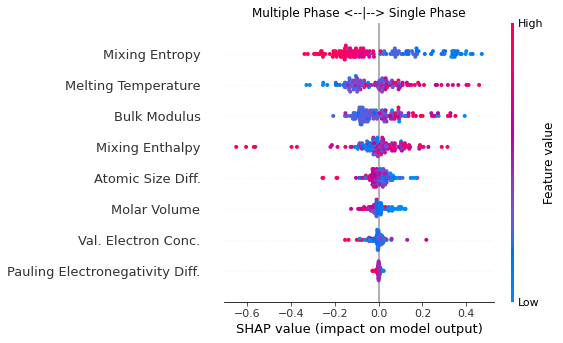

In [23]:
shap.summary_plot(shap_values[0], 
                  np.array(test_hea.loc[:, "k":"delta_h_mix"].values, np.float32), 
                  feature_names, show=False,)
plt.title('Multiple Phase <--|--> Single Phase')
# plt.savefig("Test_SHAP.pdf", dpi=500)
plt.show()
plt.close()

**Individual Test Example force and waterfall plots**

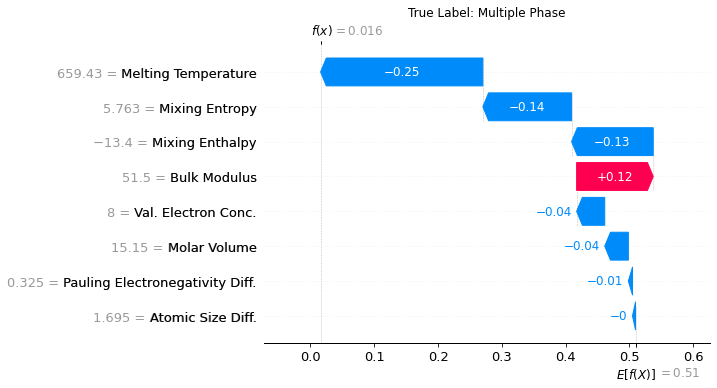

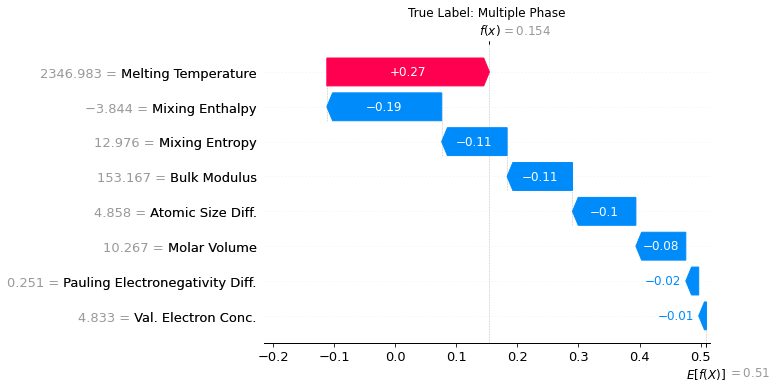

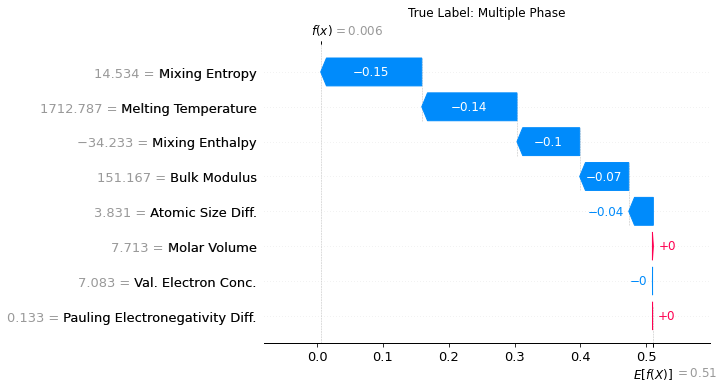

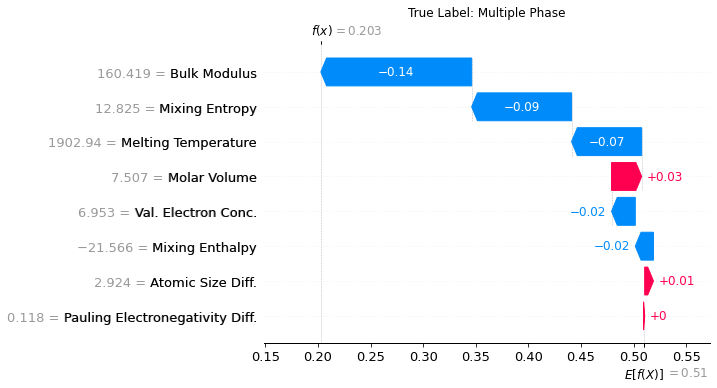

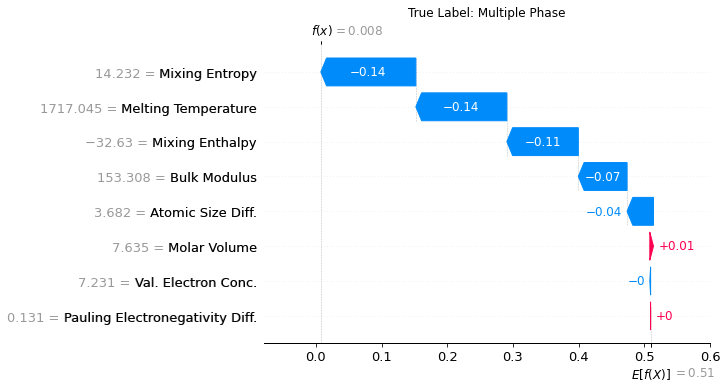

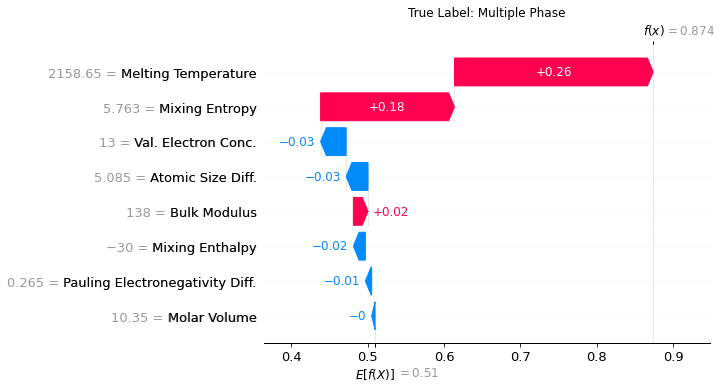

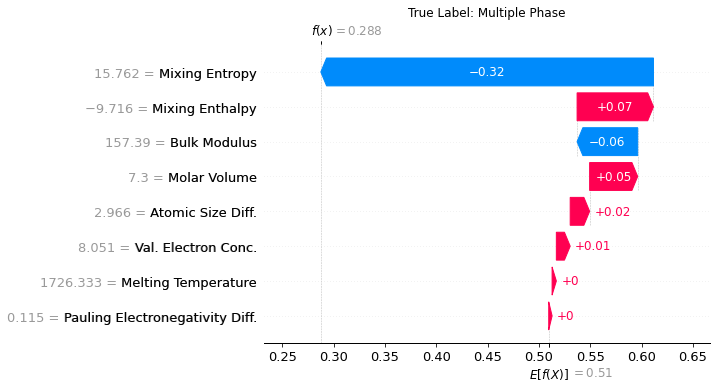

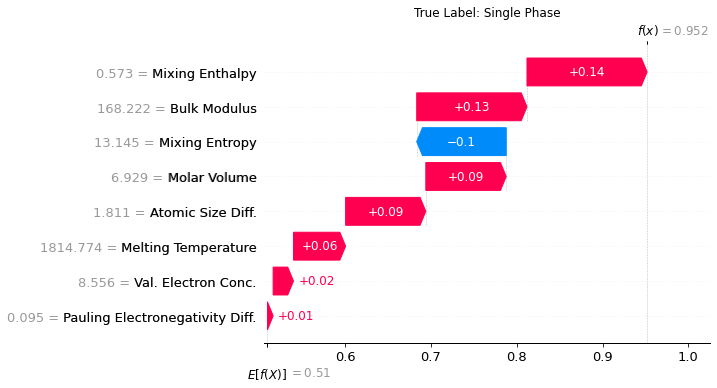

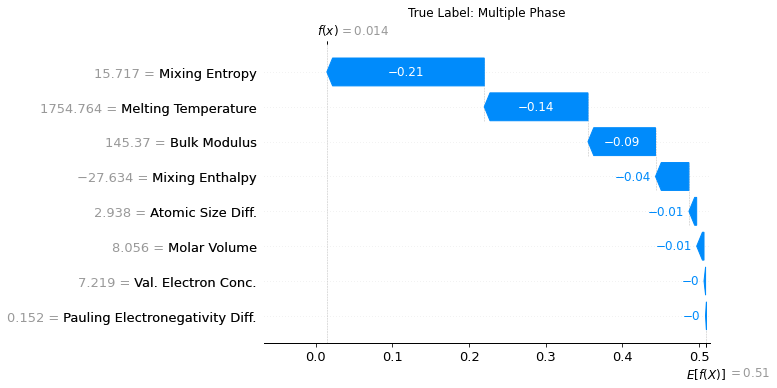

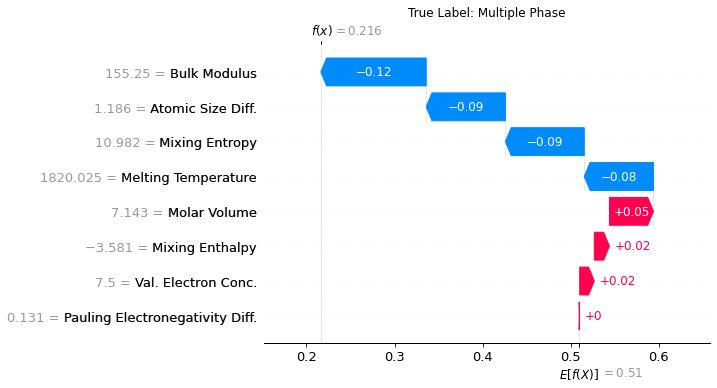

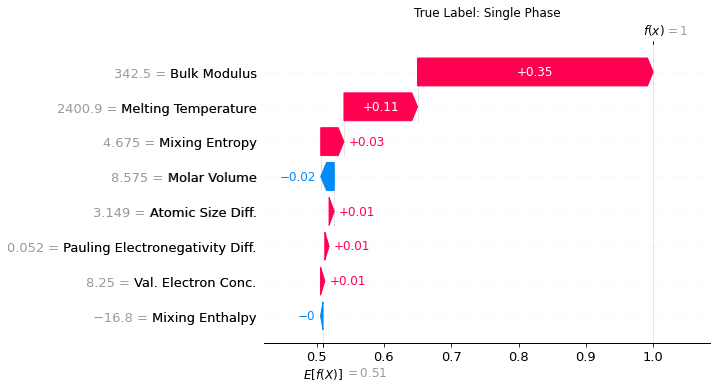

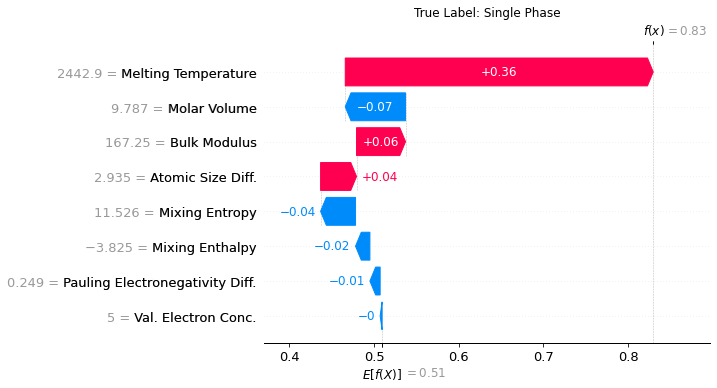

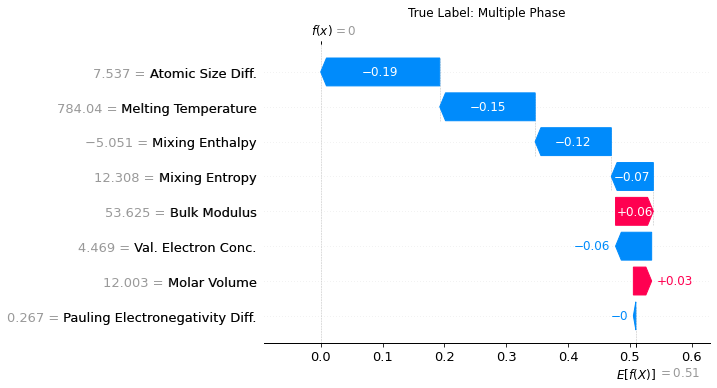

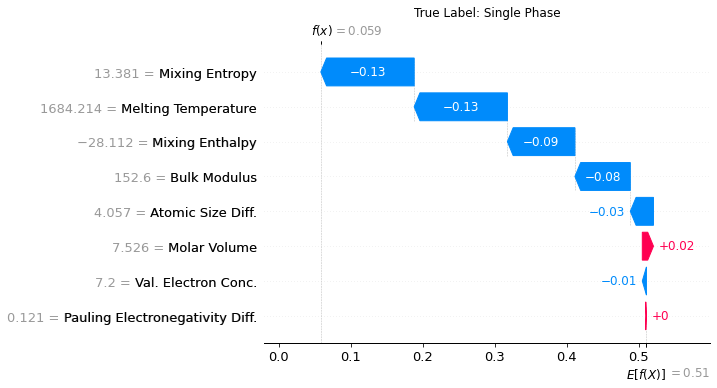

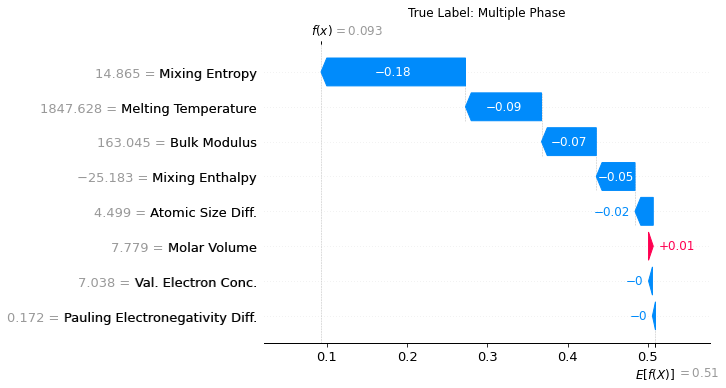

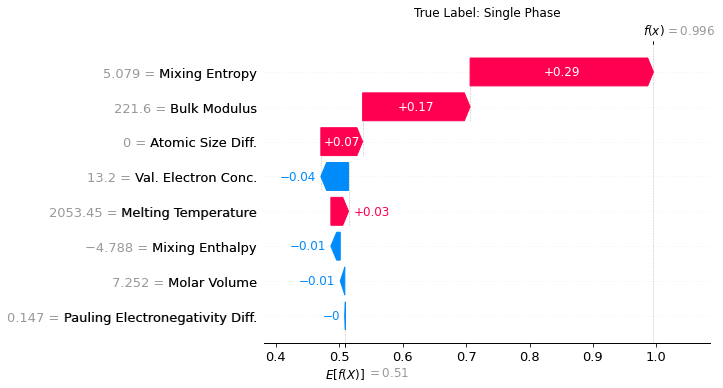

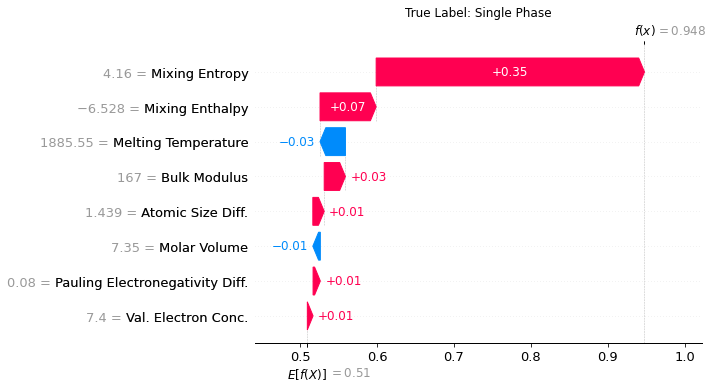

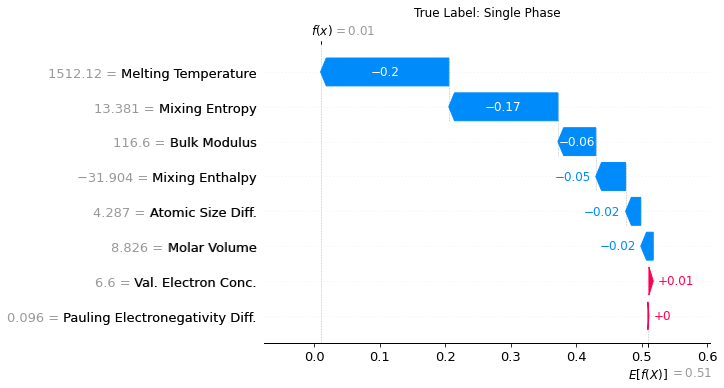

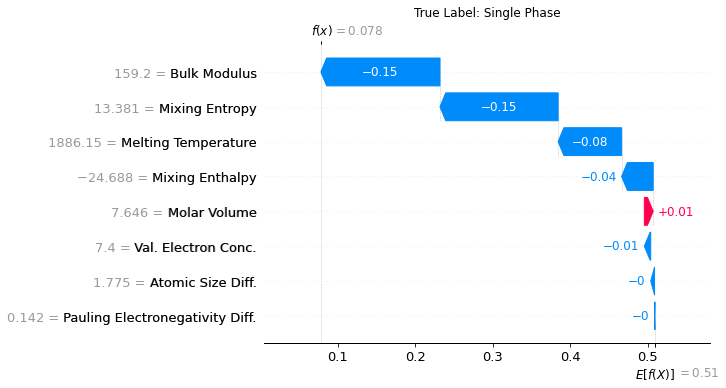

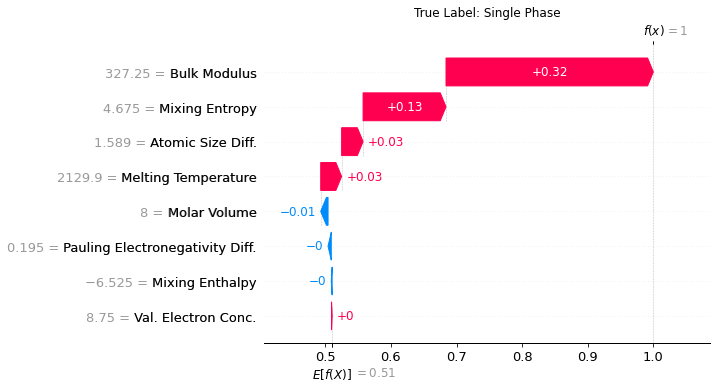

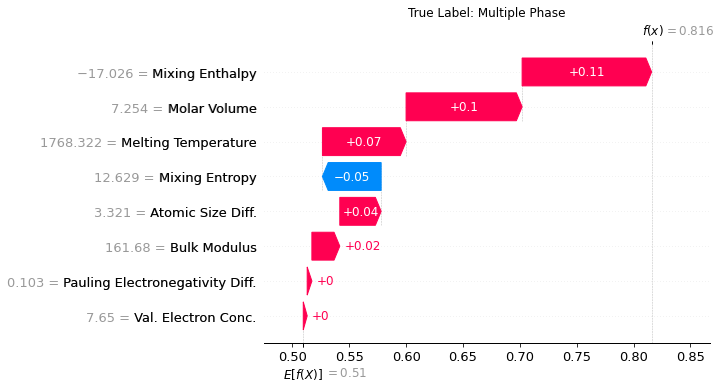

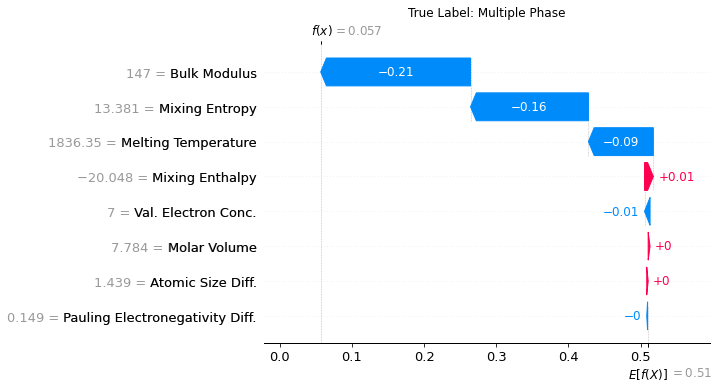

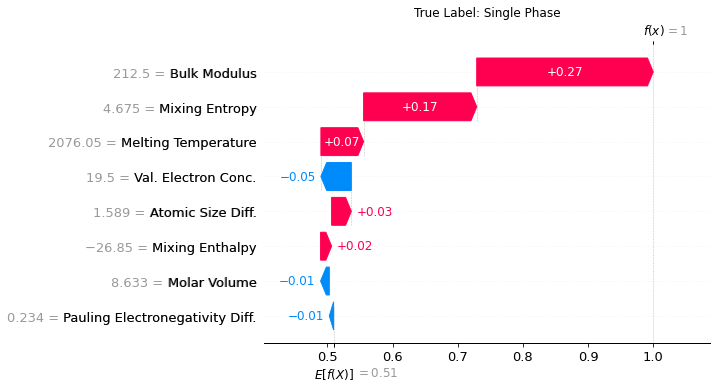

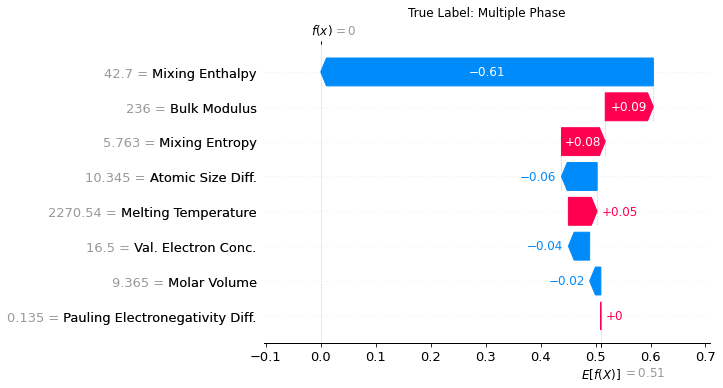

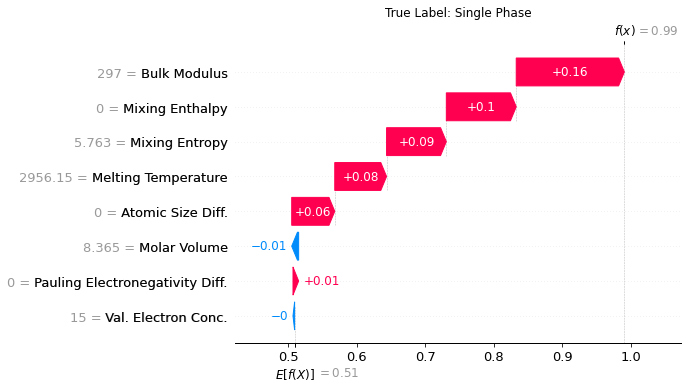

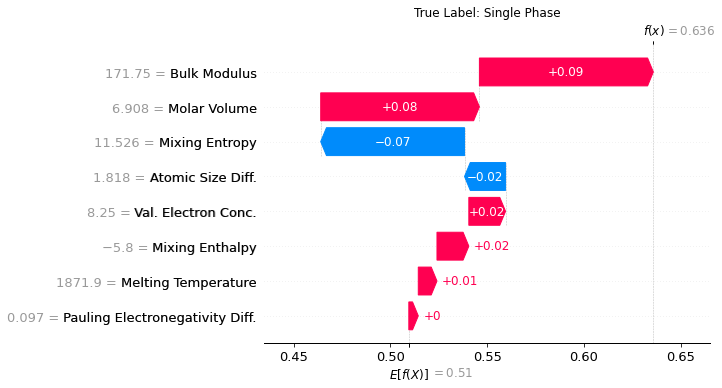

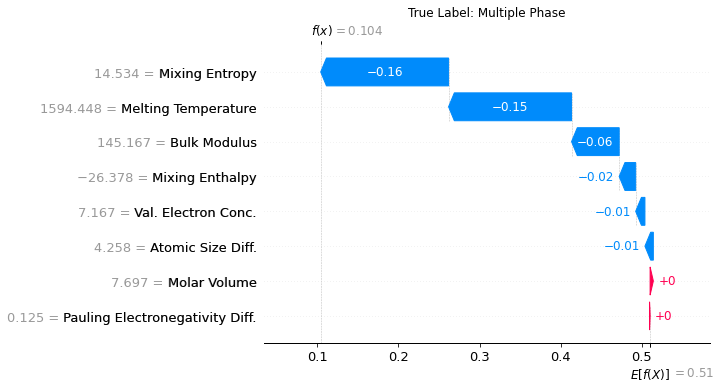

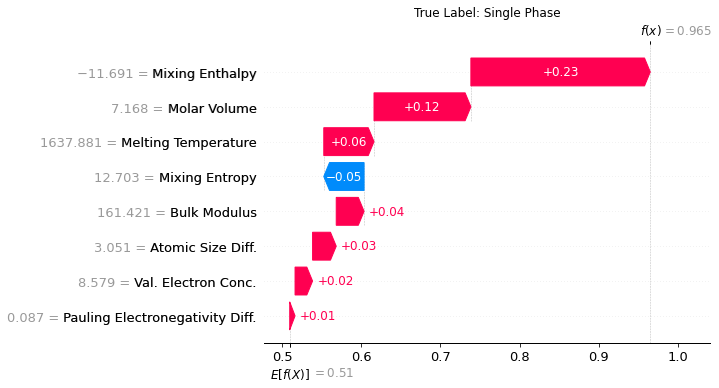

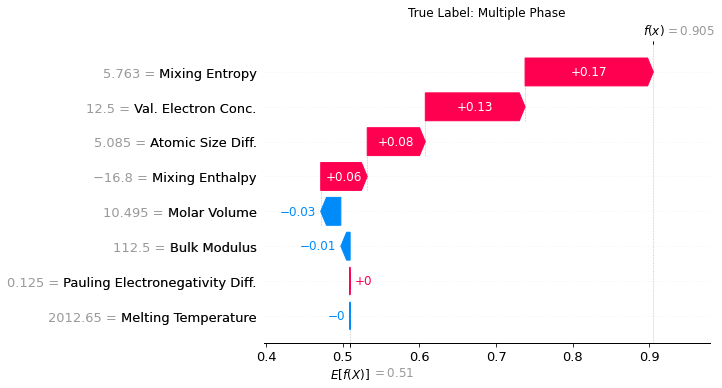

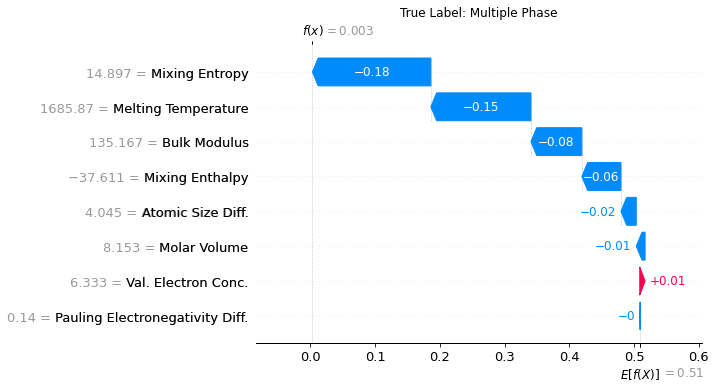

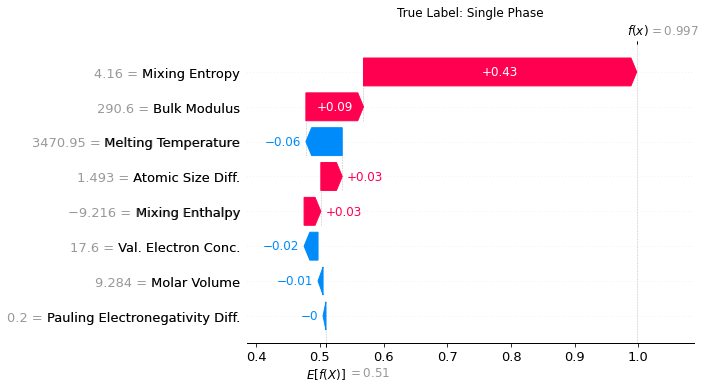

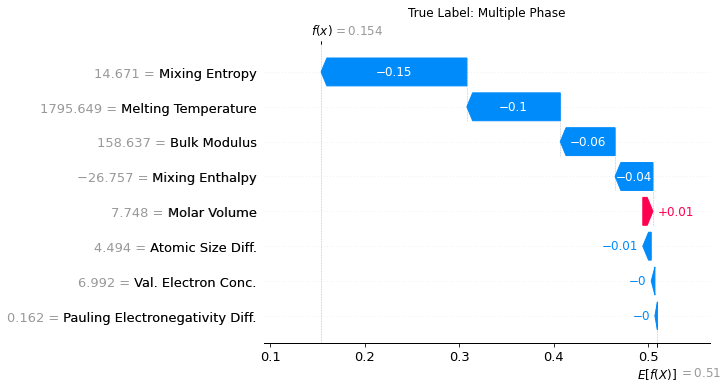

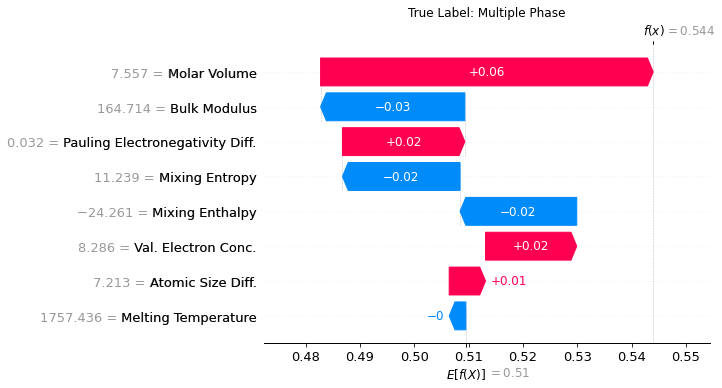

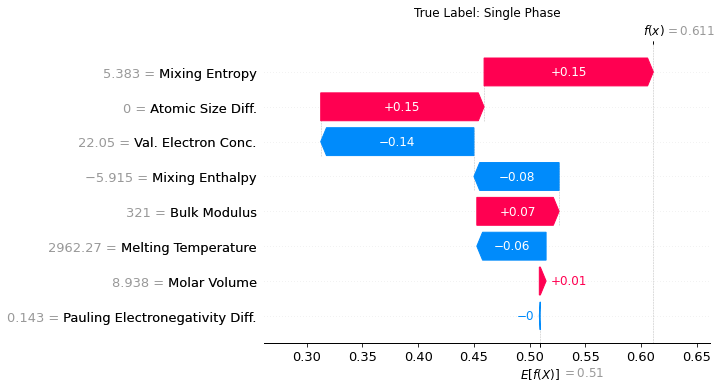

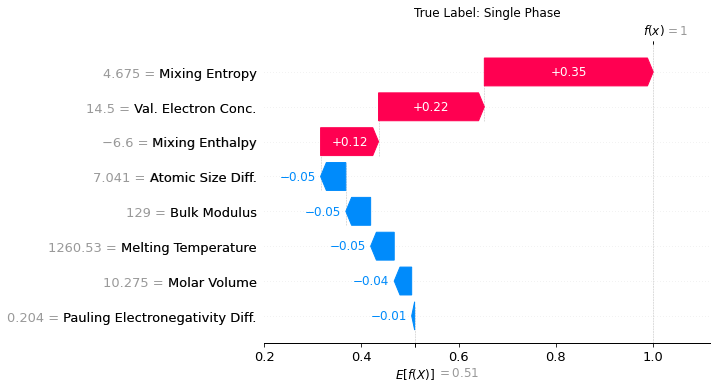

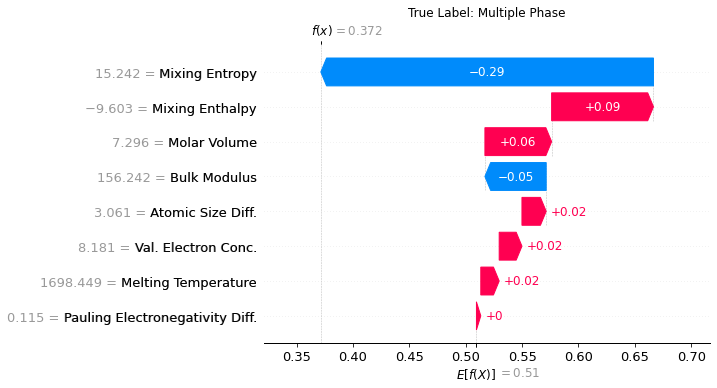

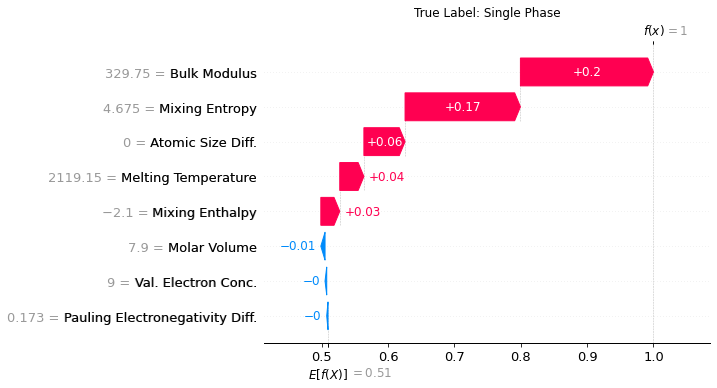

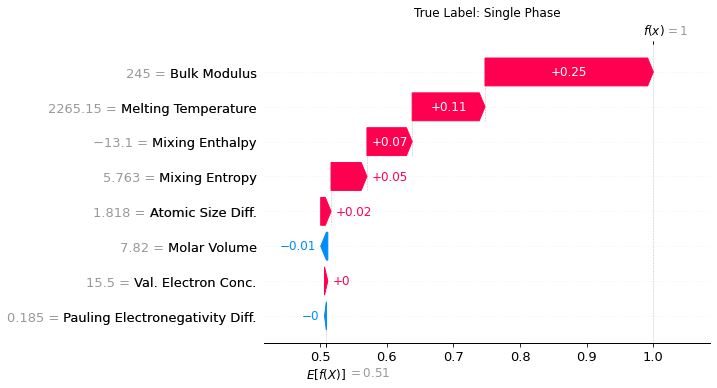

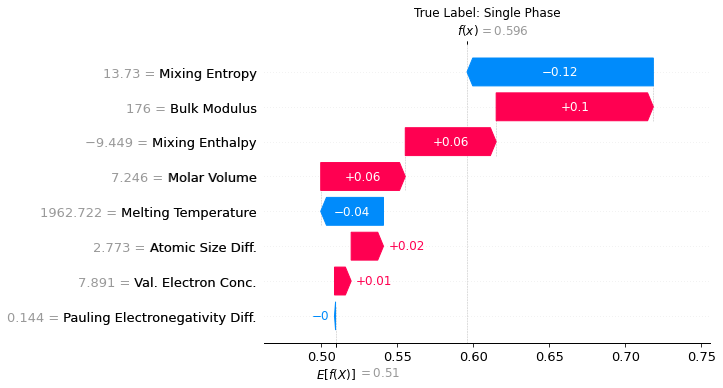

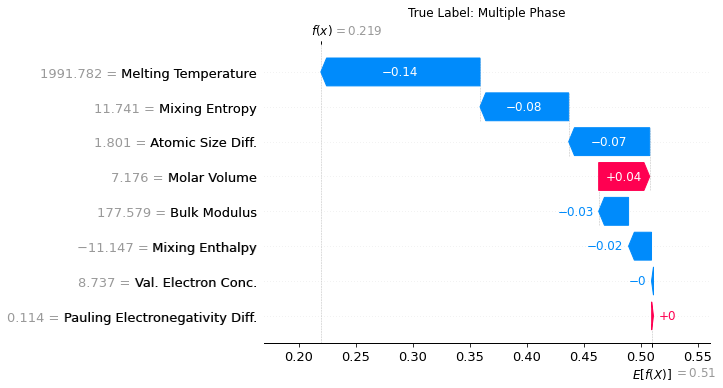

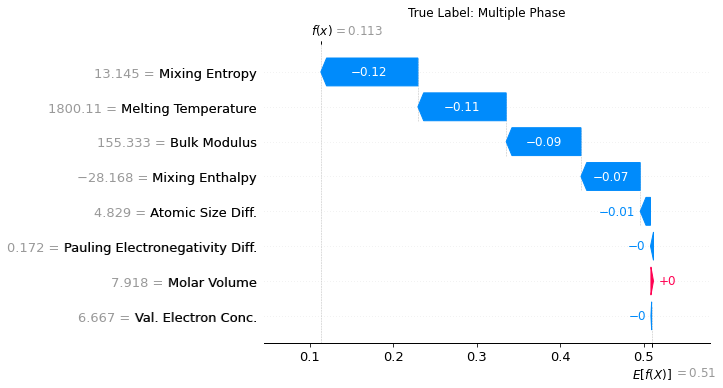

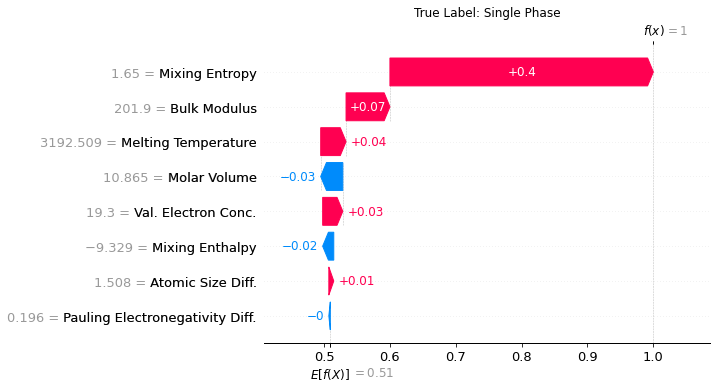

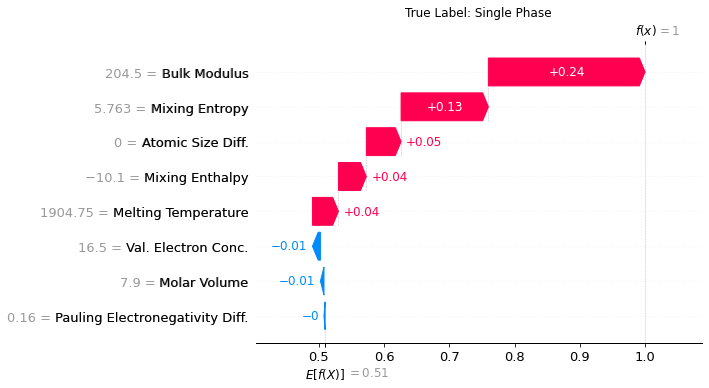

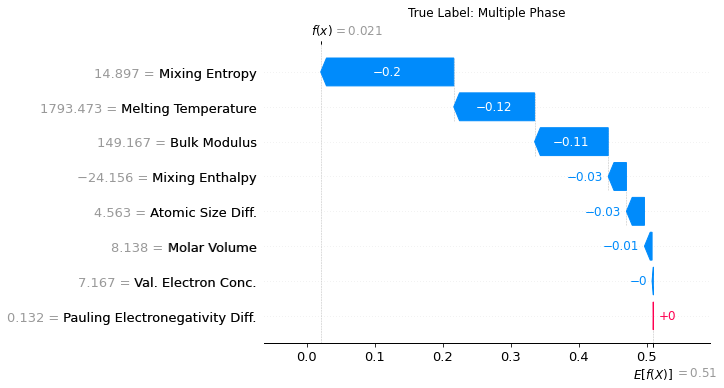

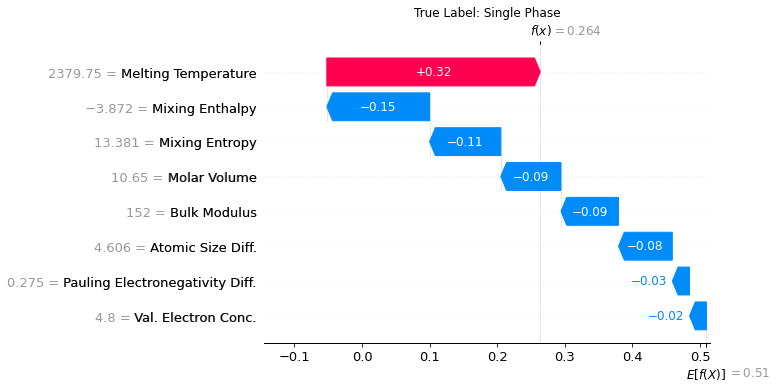

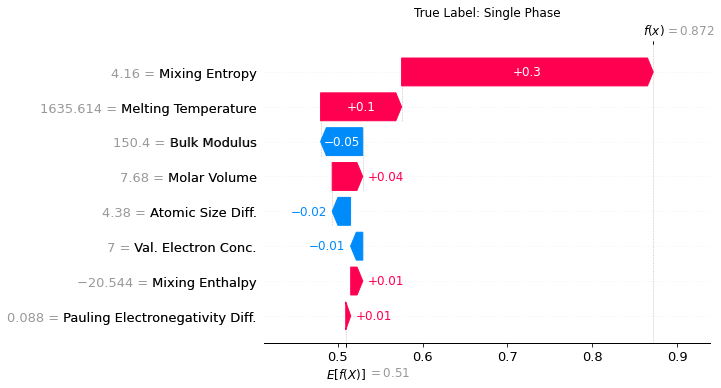

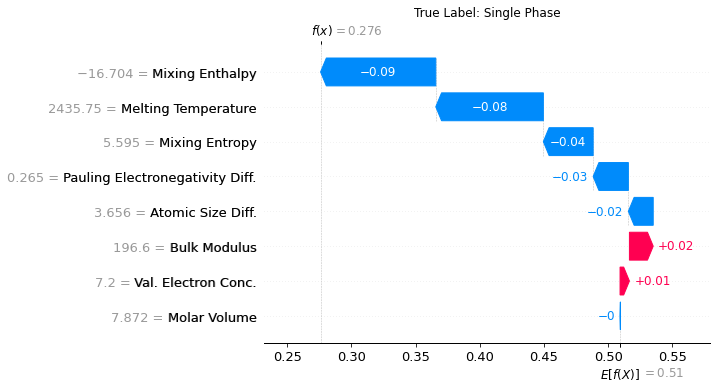

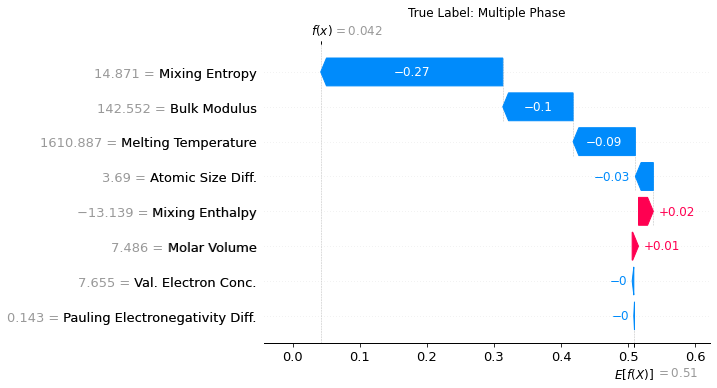

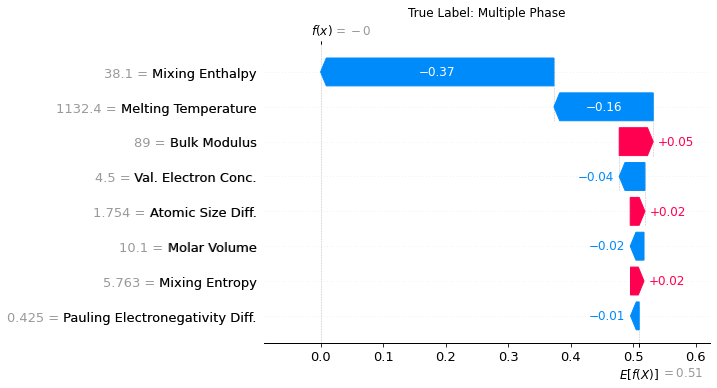

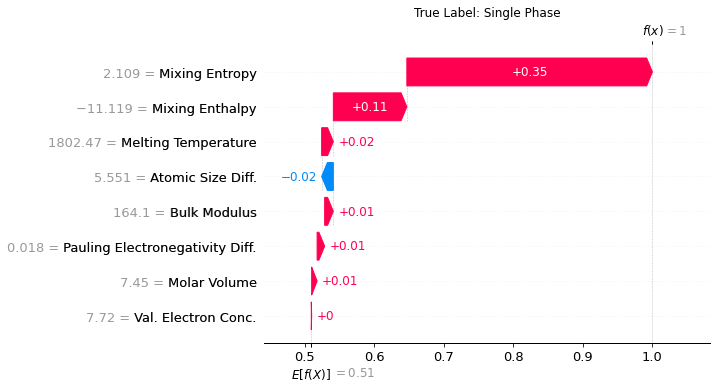

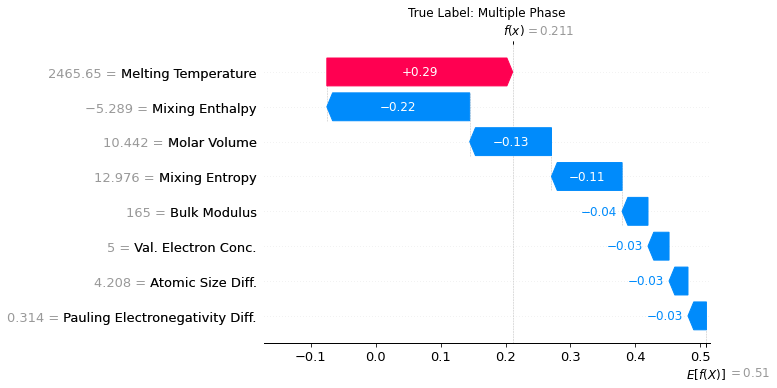

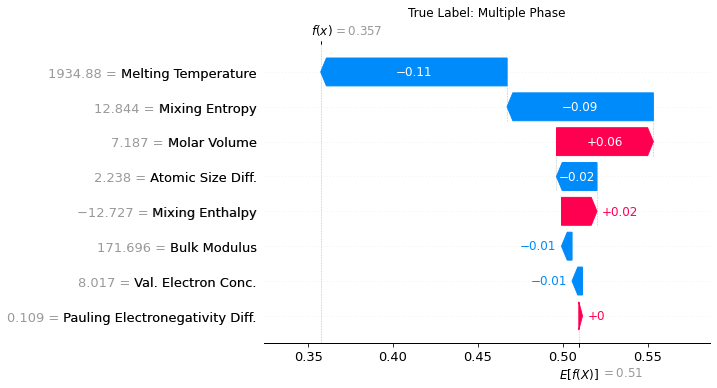

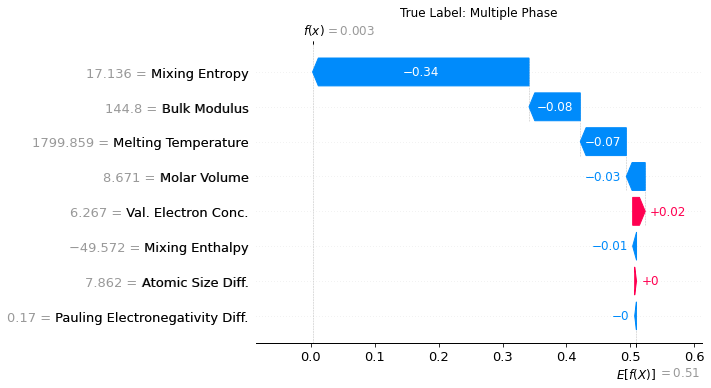

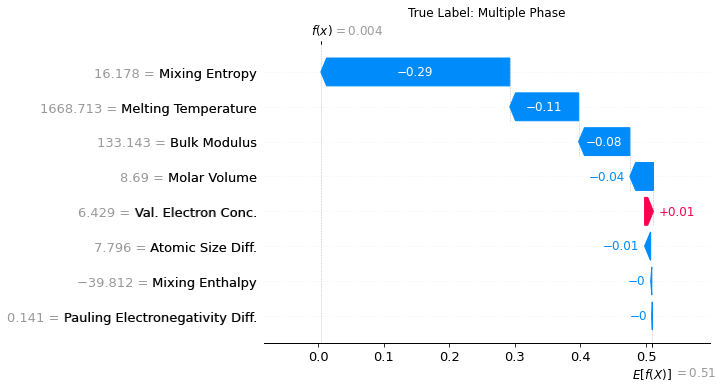

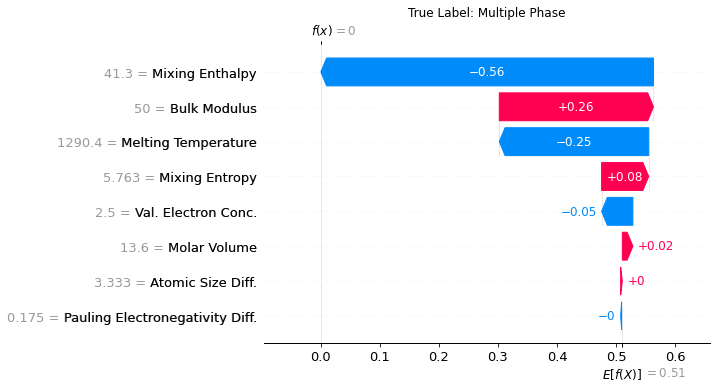

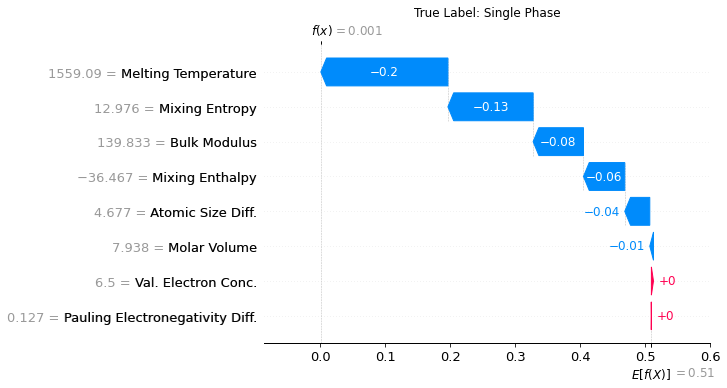

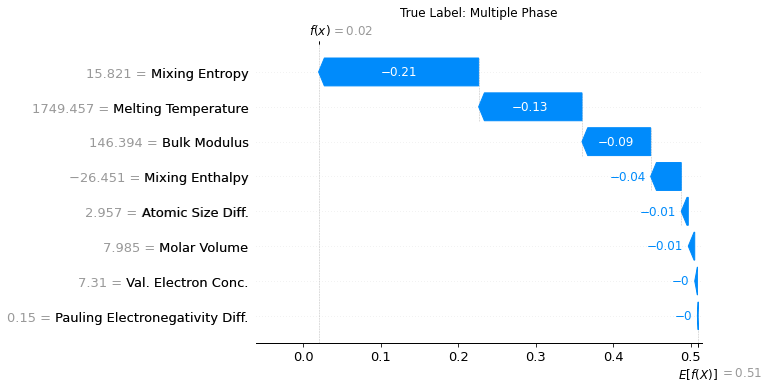

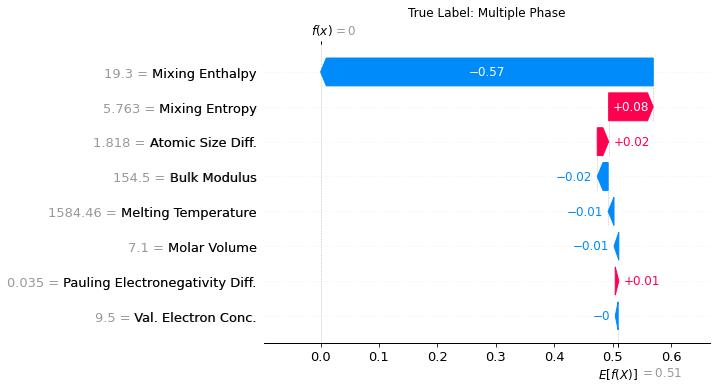

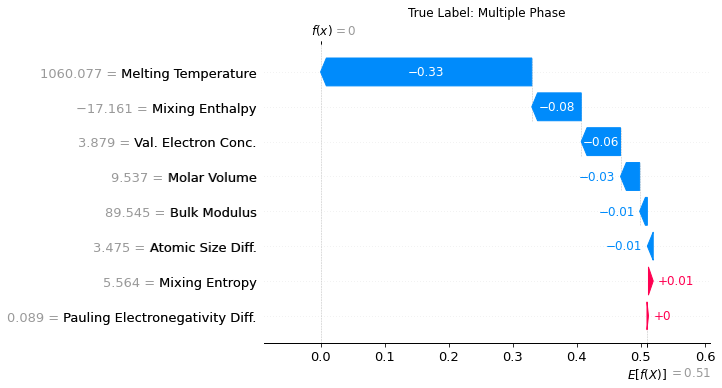

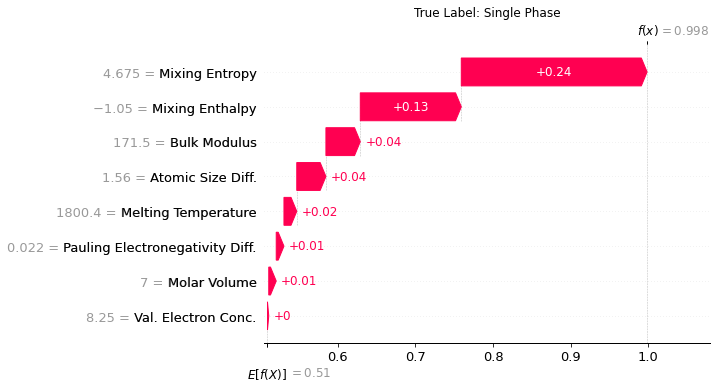

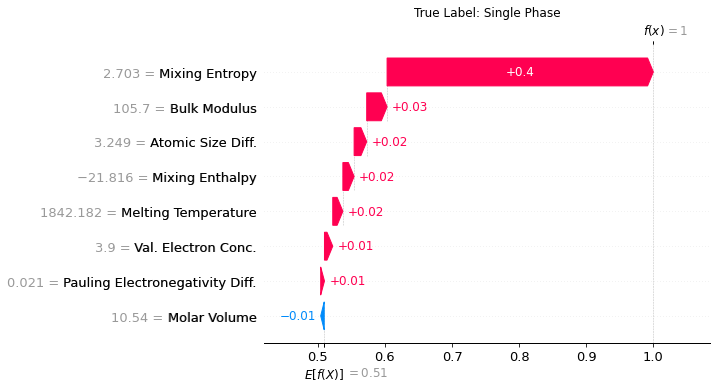

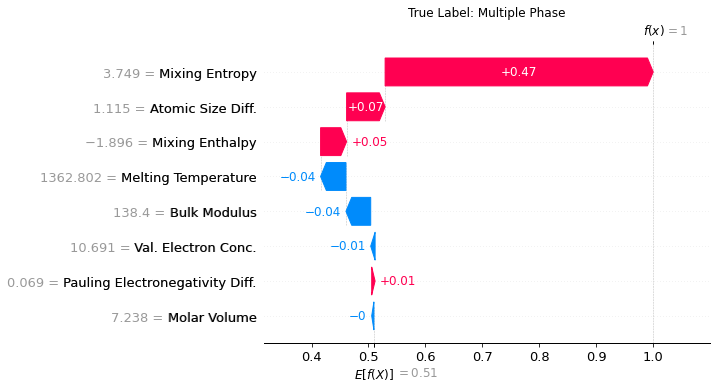

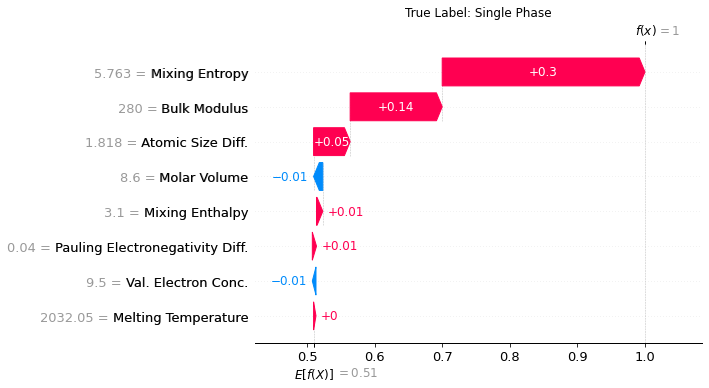

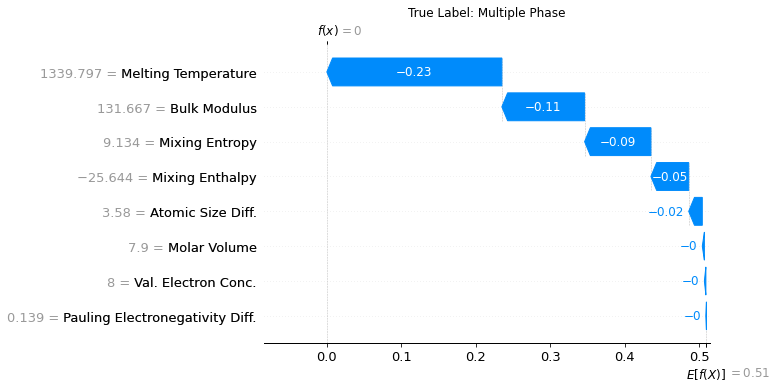

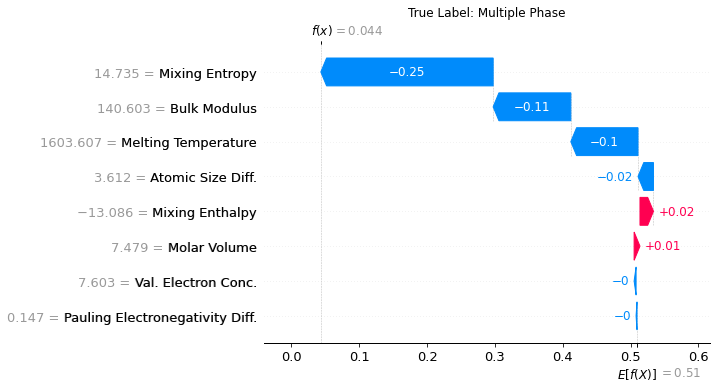

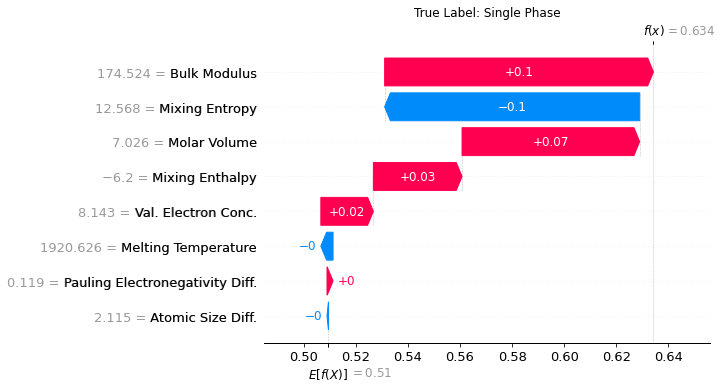

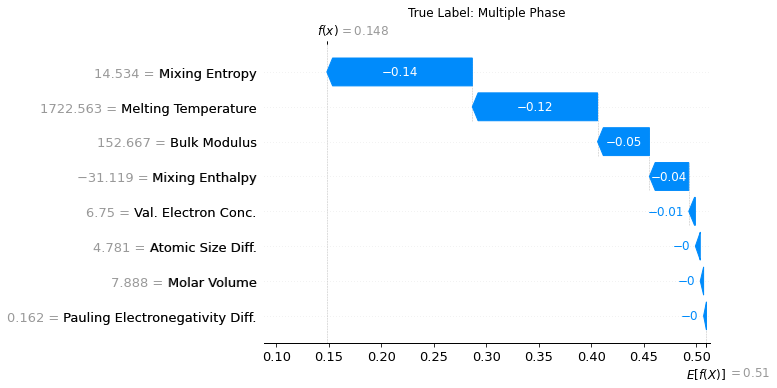

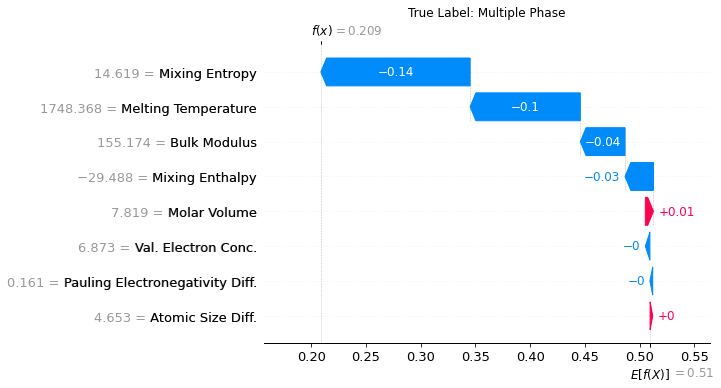

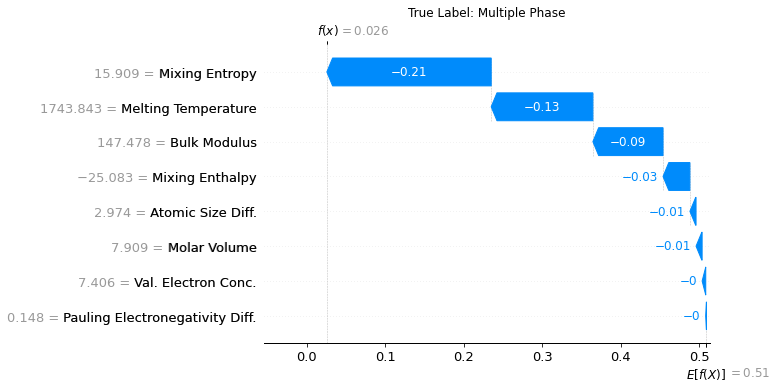

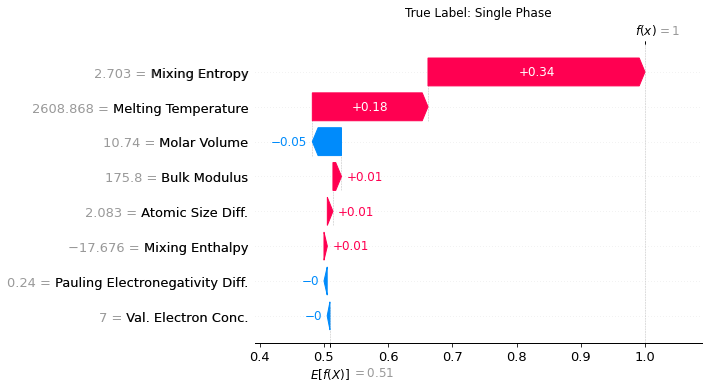

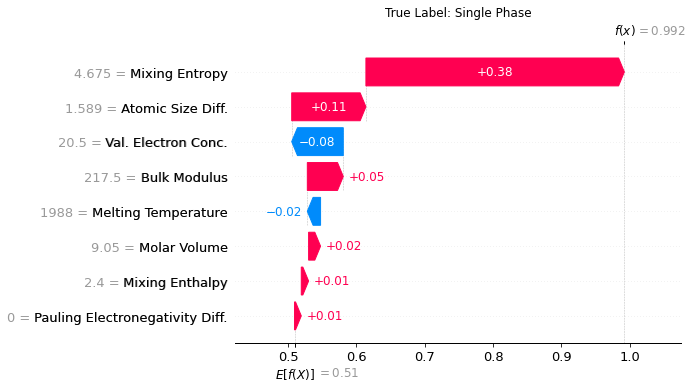

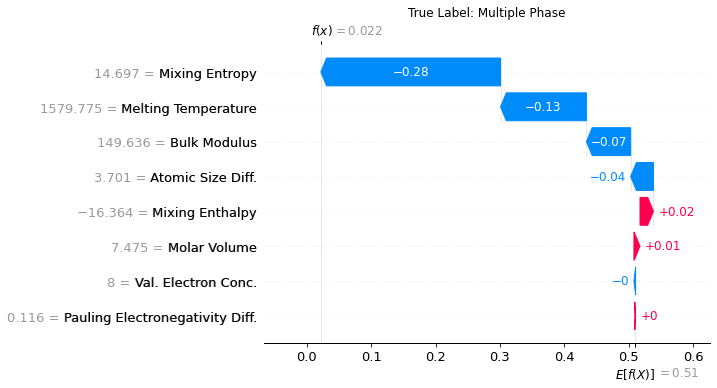

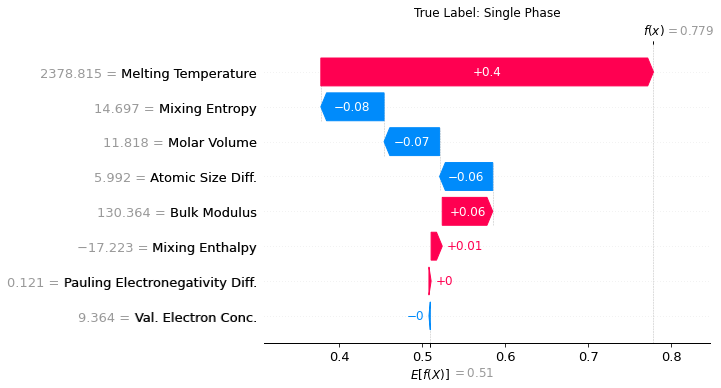

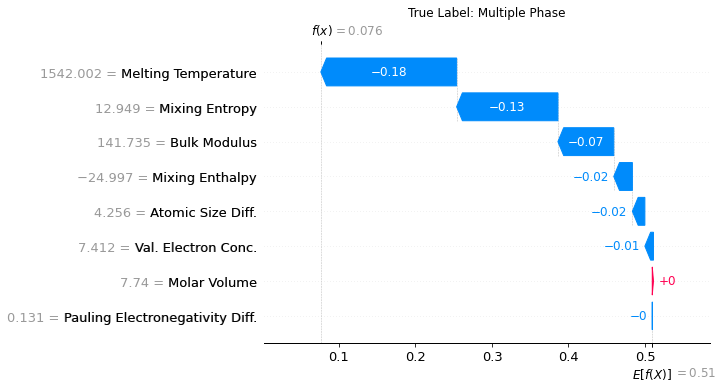

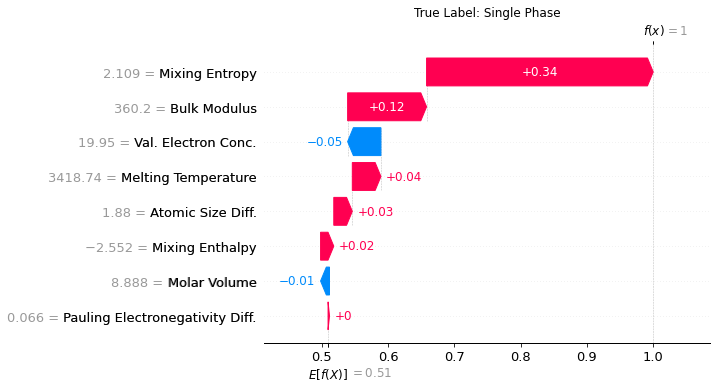

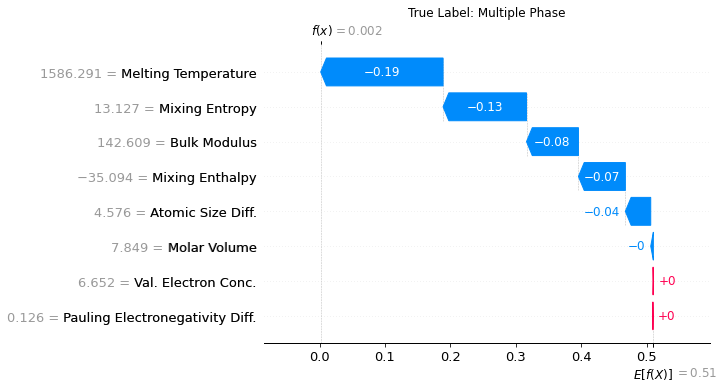

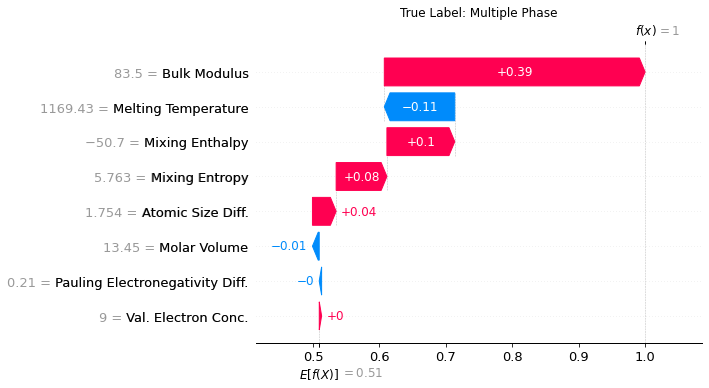

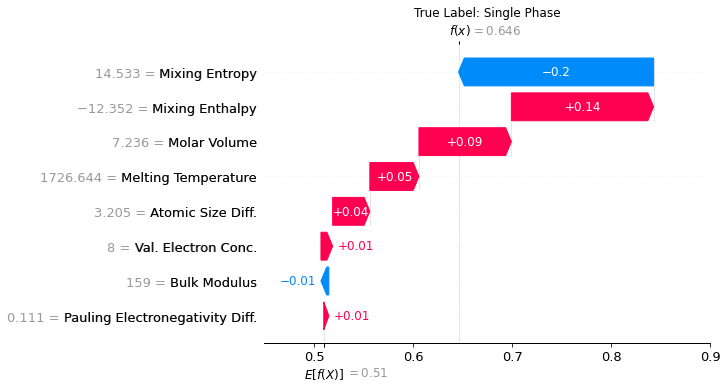

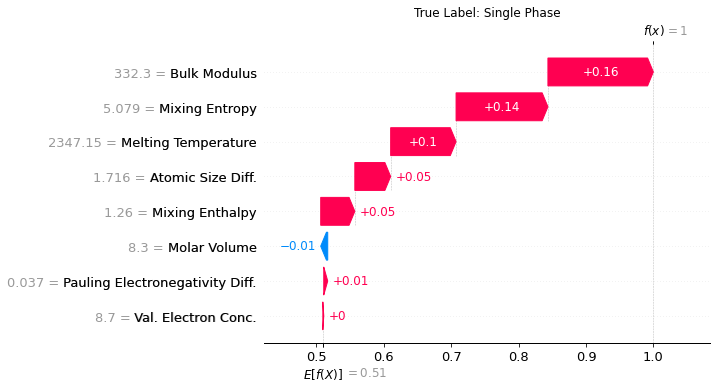

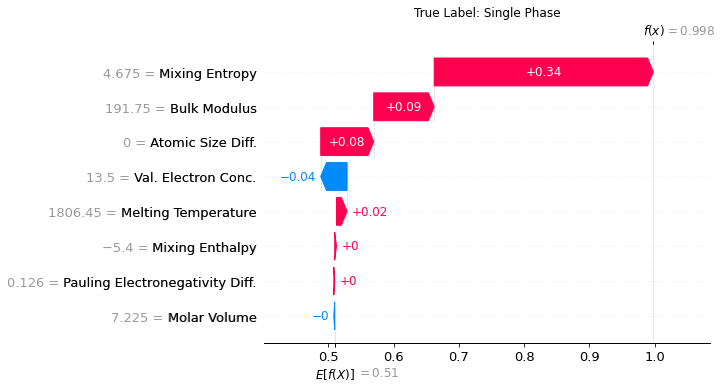

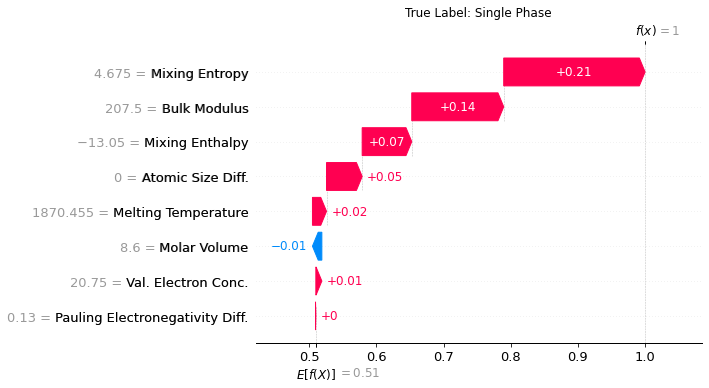

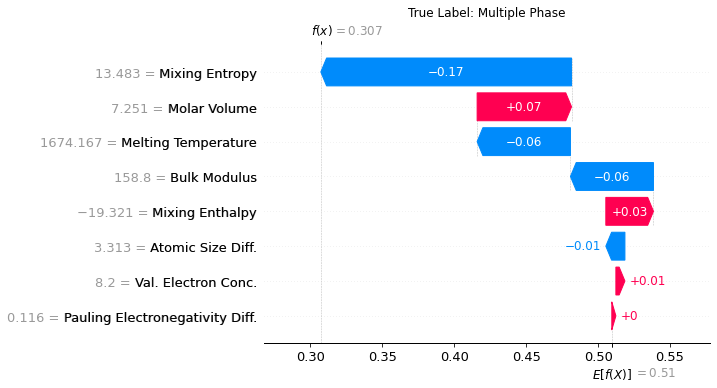

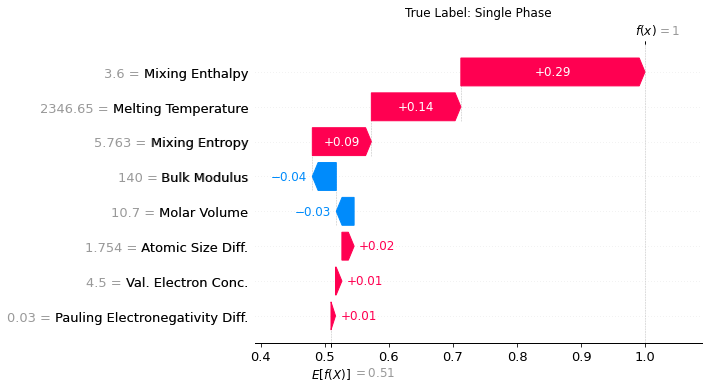

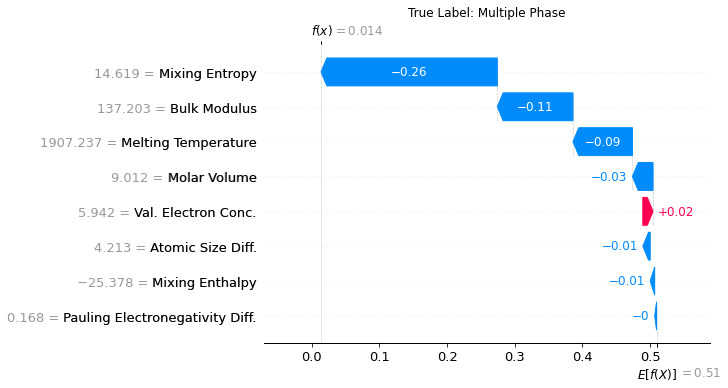

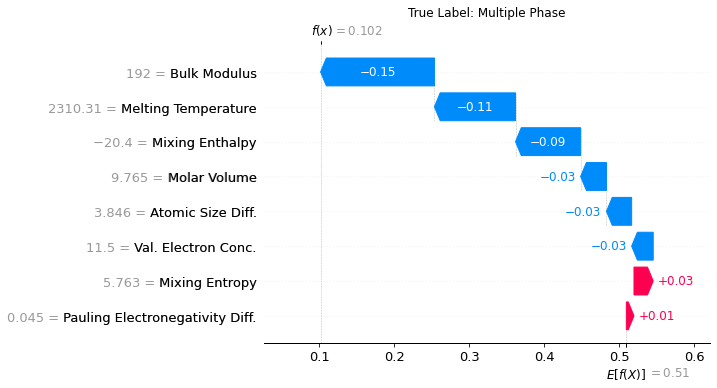

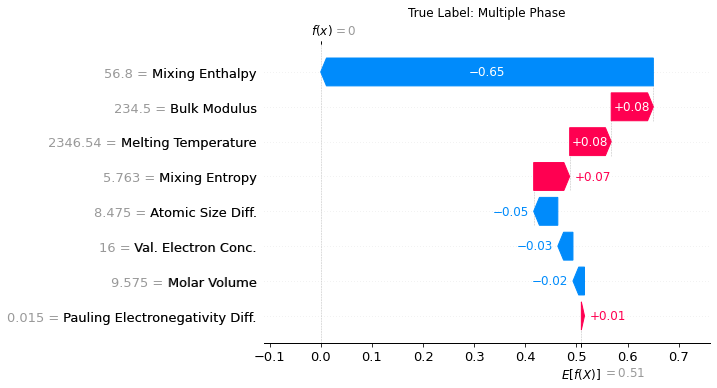

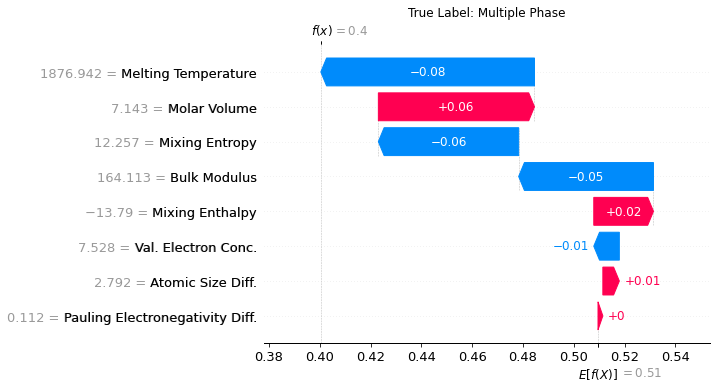

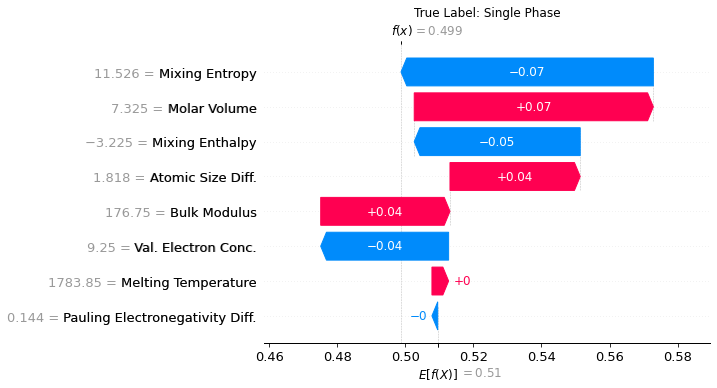

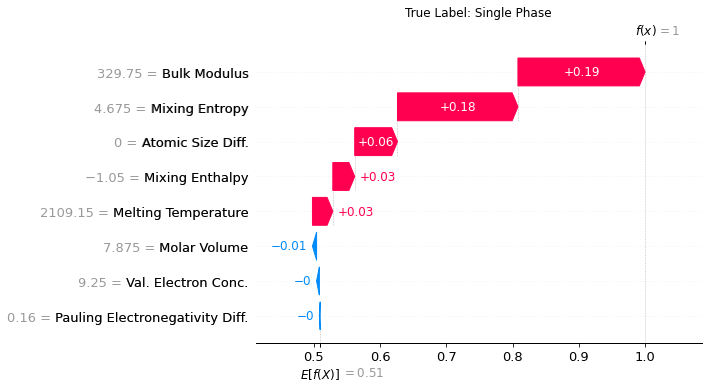

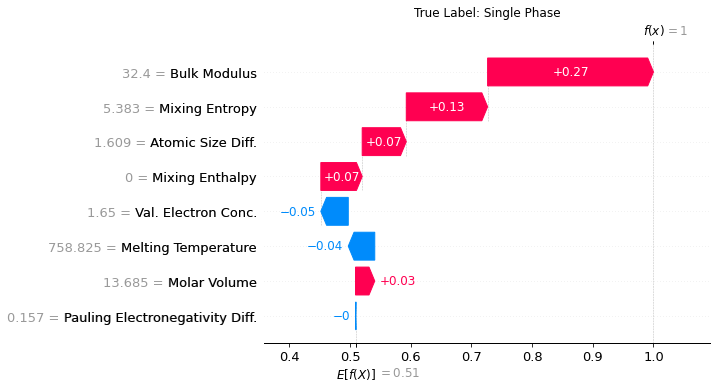

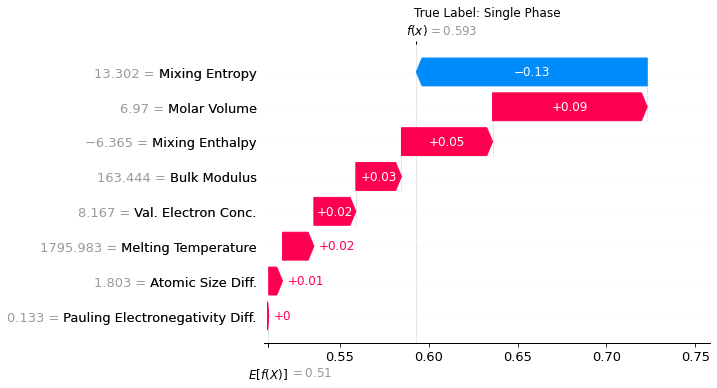

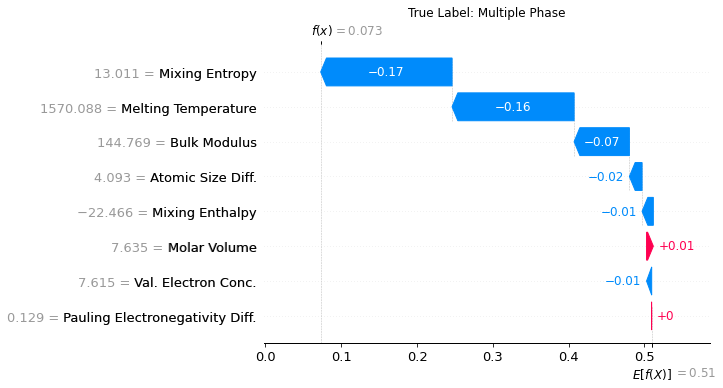

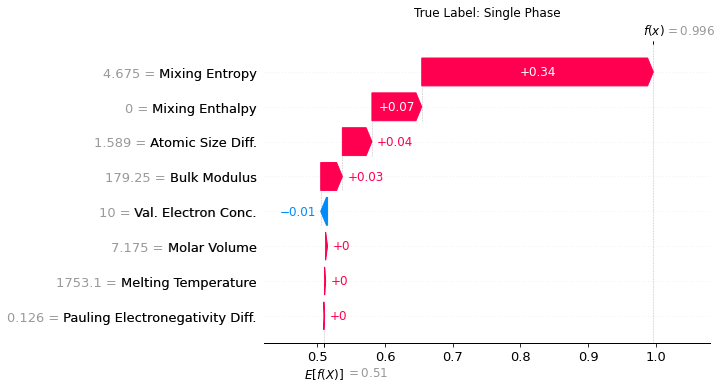

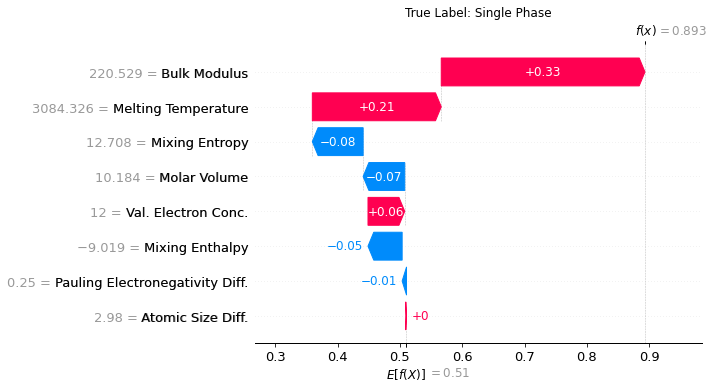

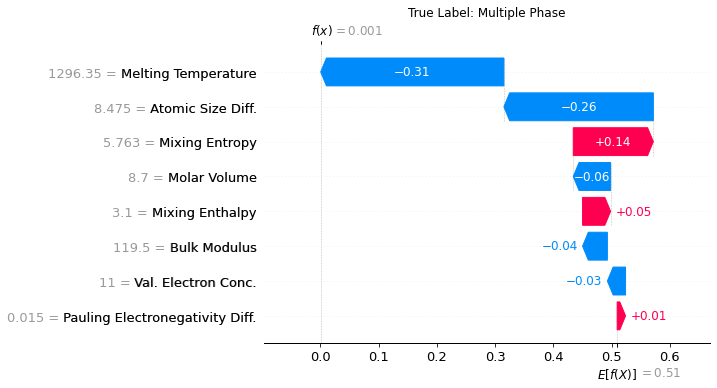

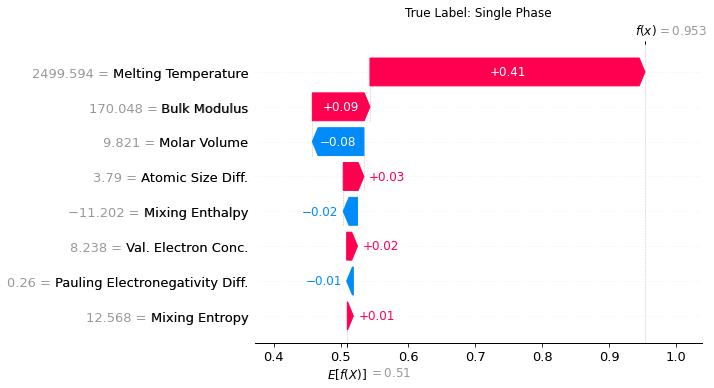

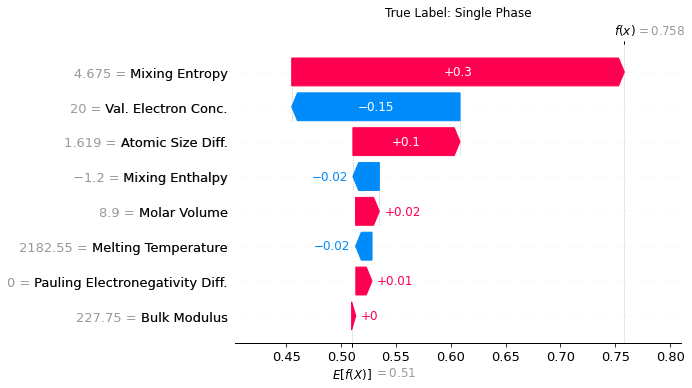

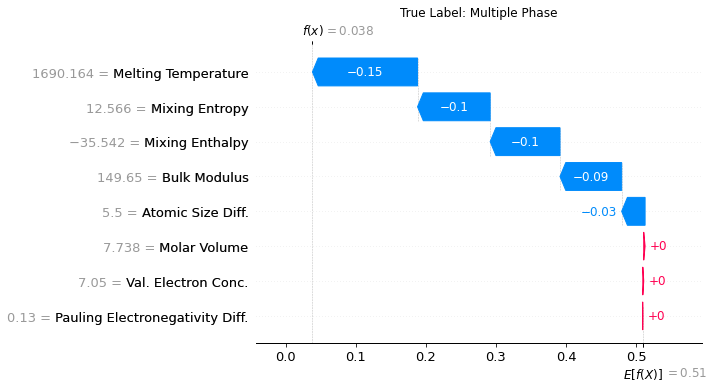

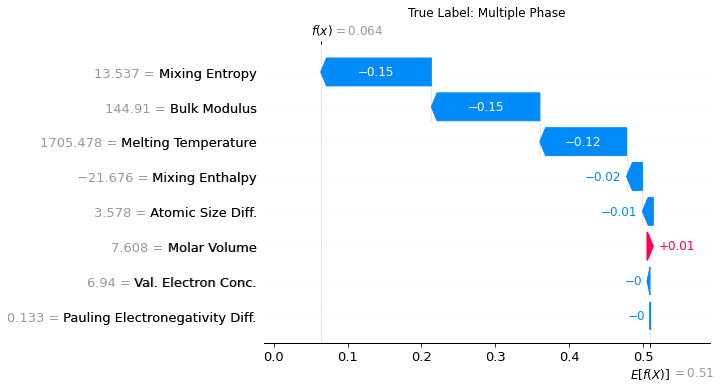

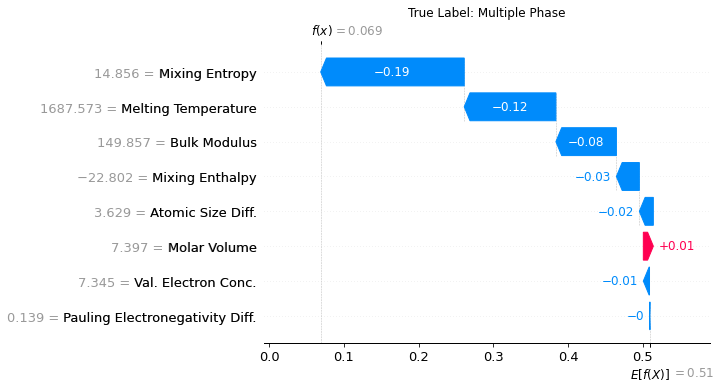

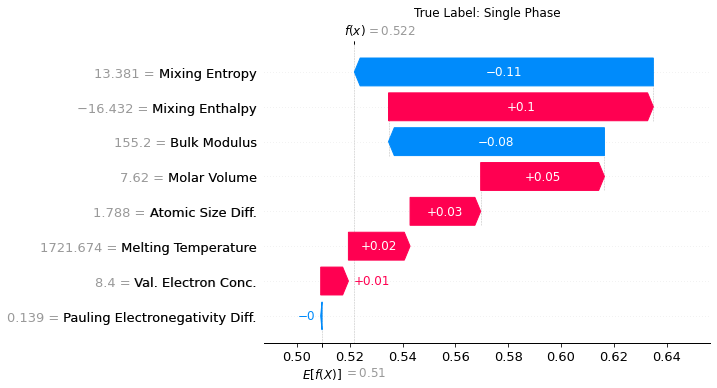

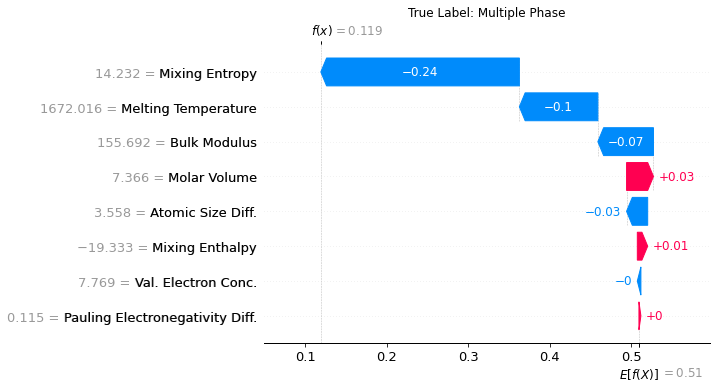

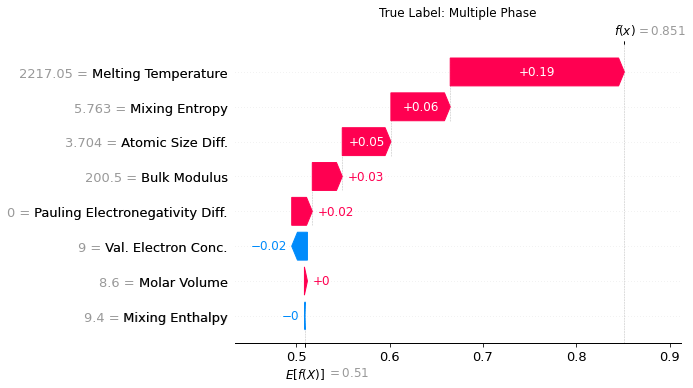

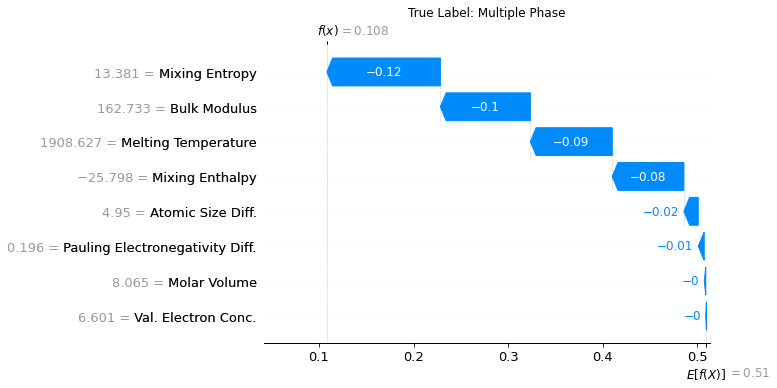

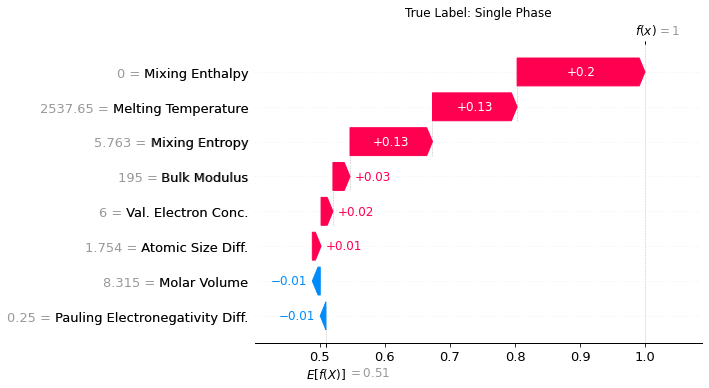

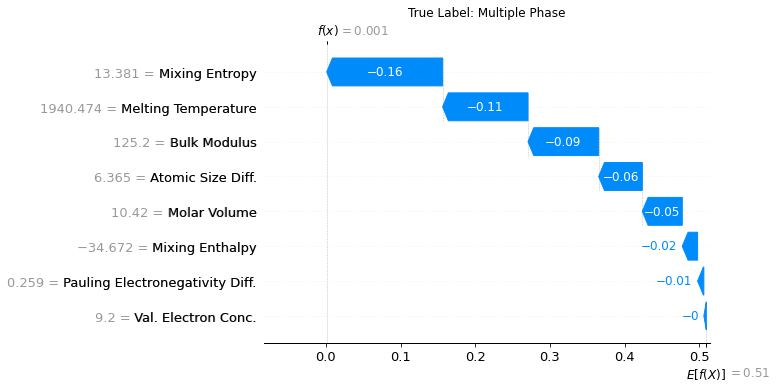

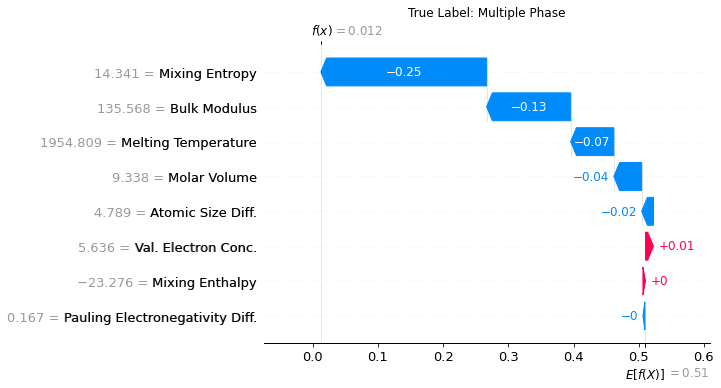

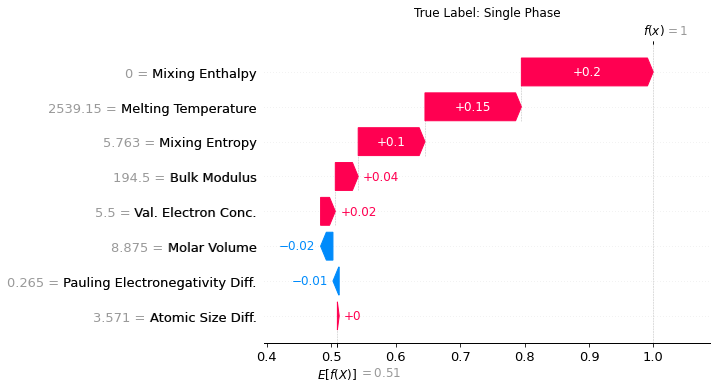

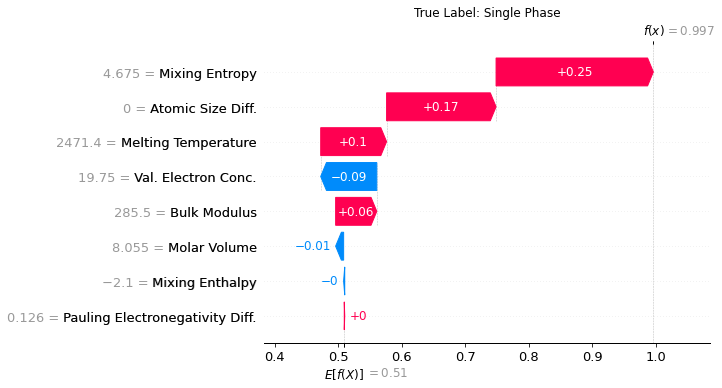

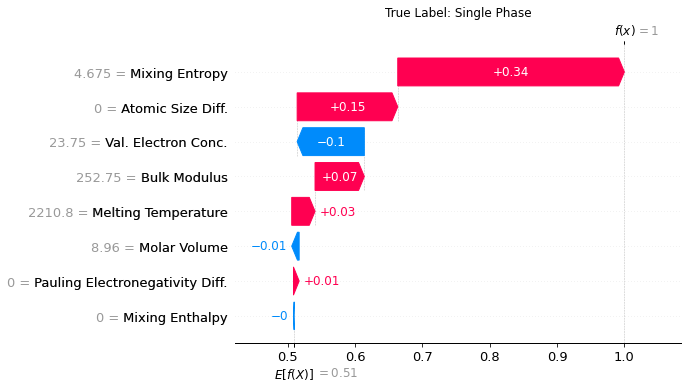

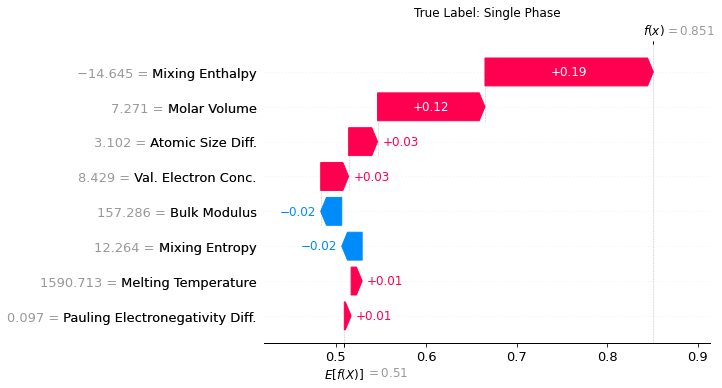

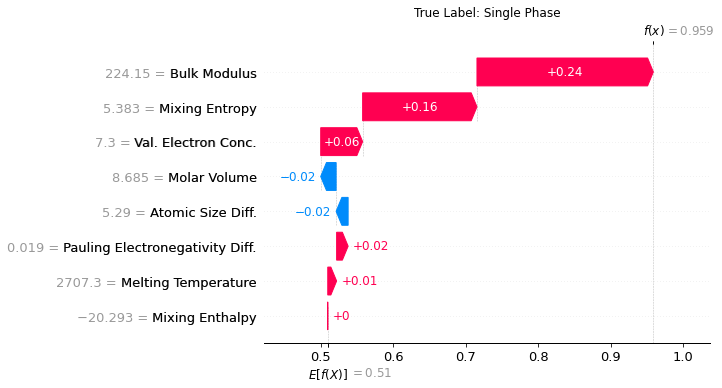

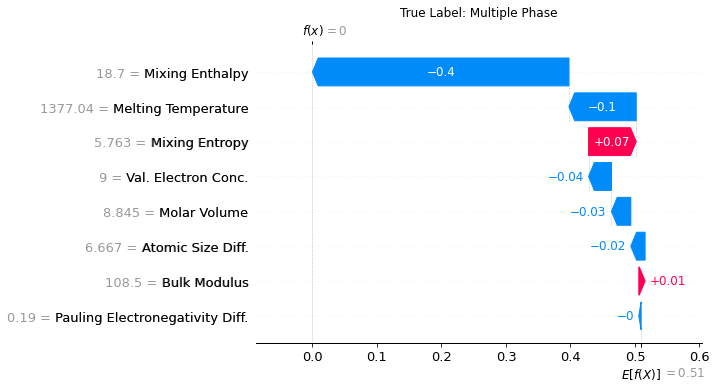

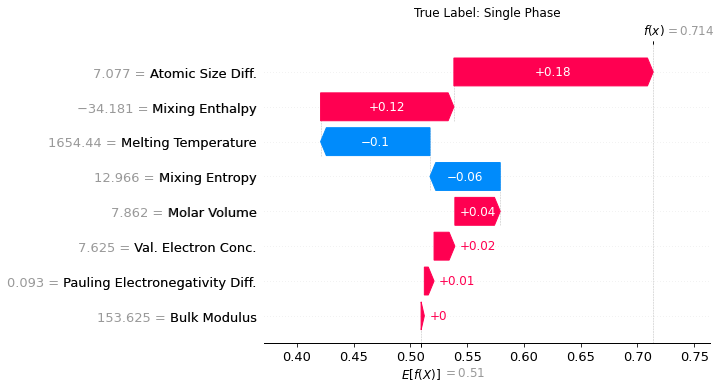

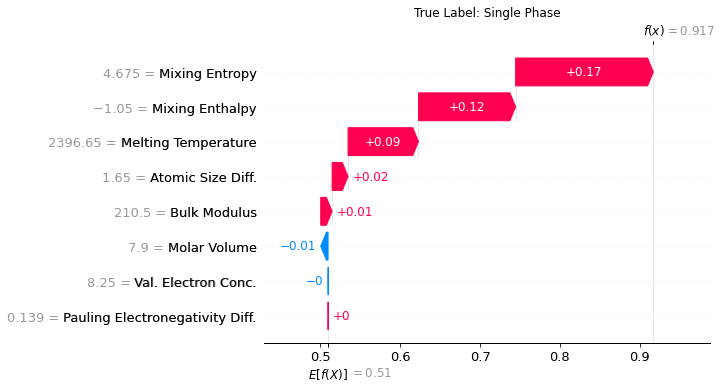

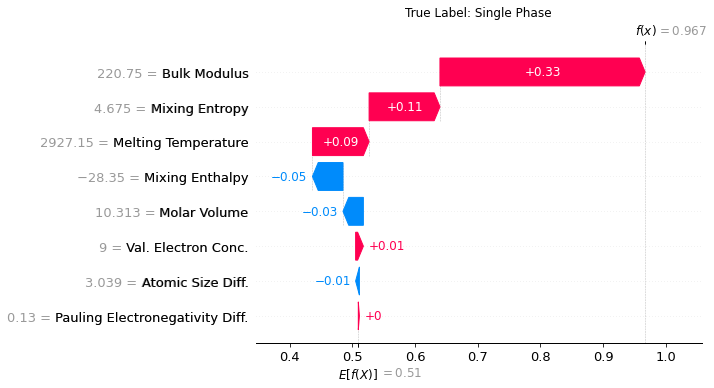

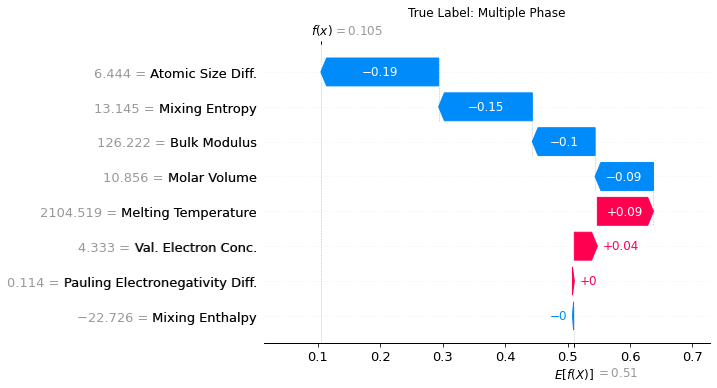

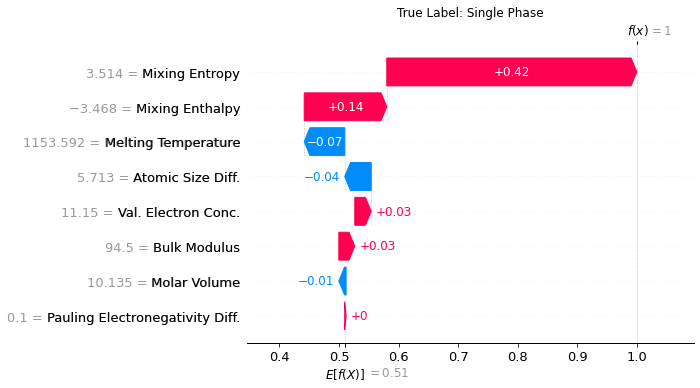

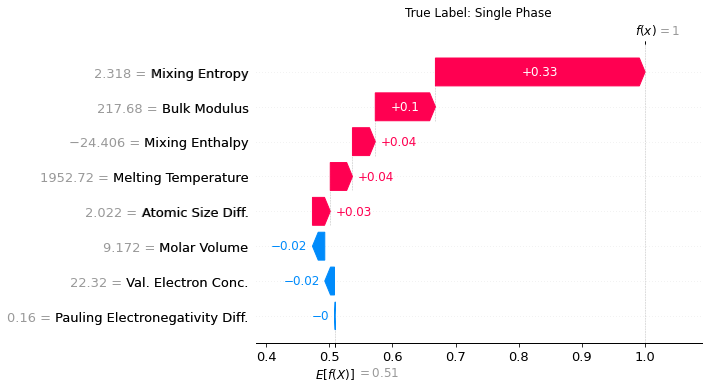

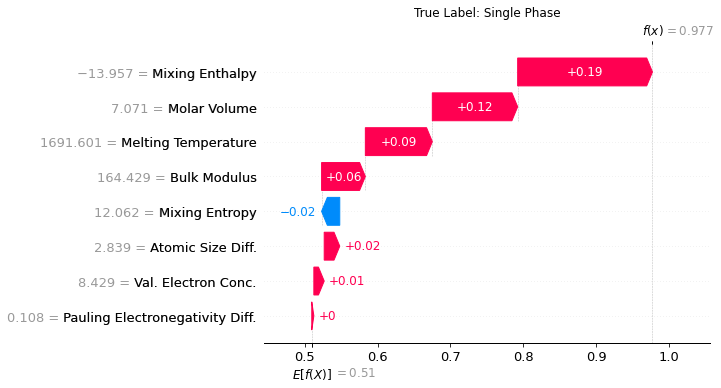

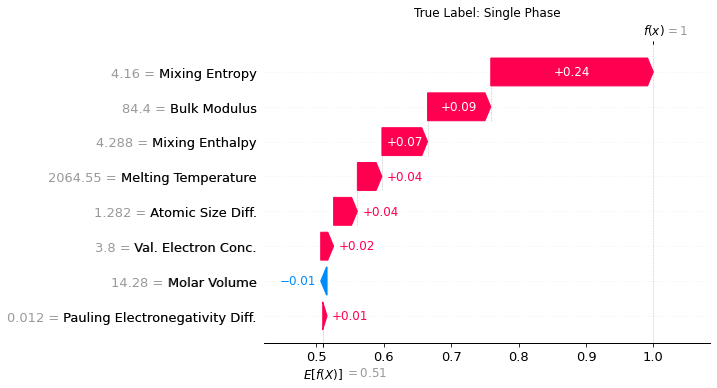

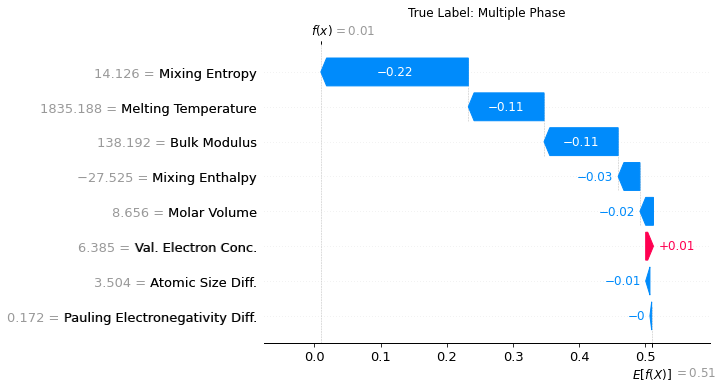

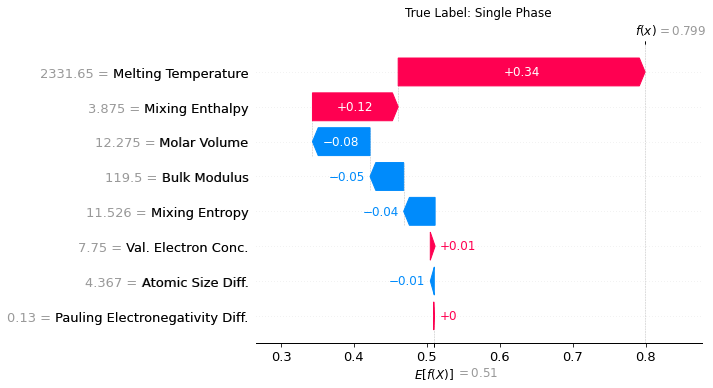

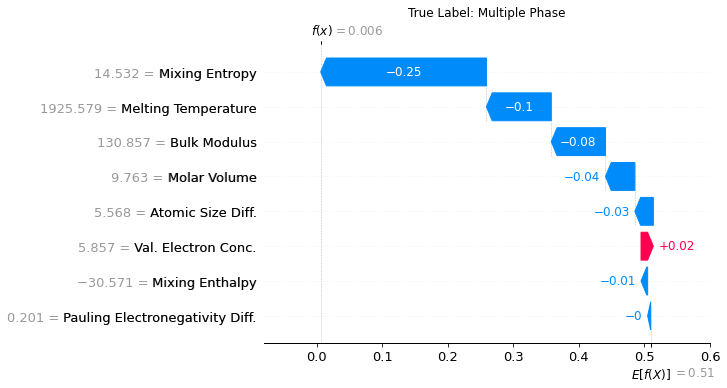

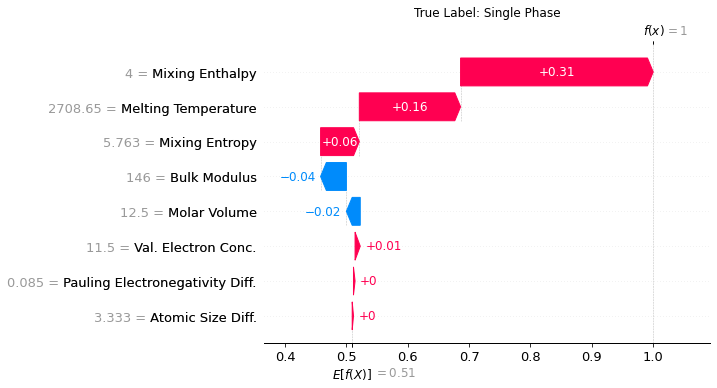

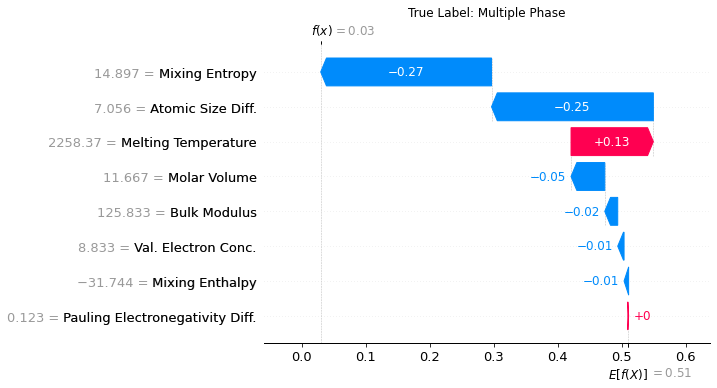

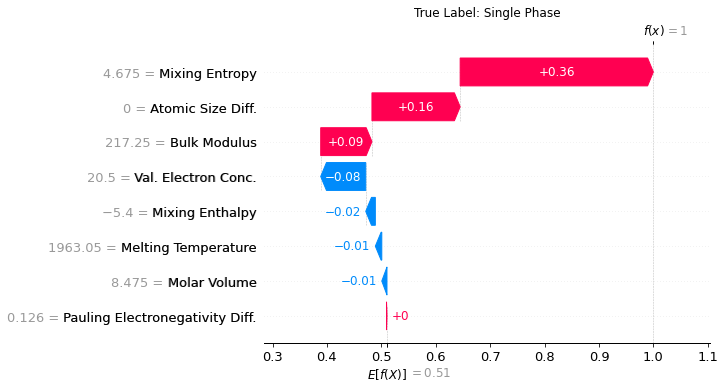

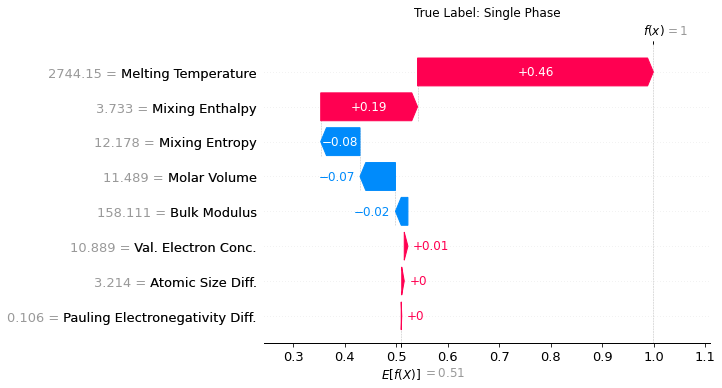

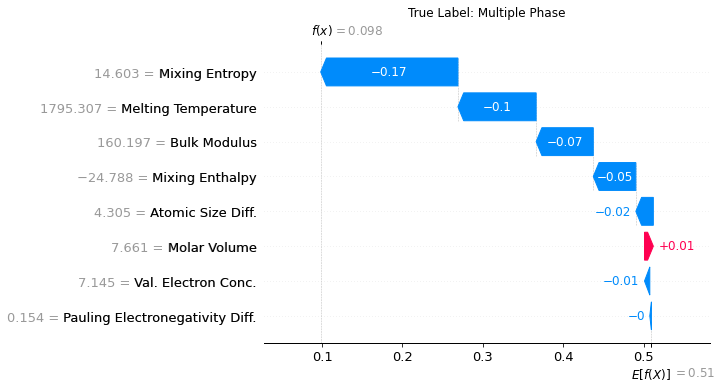

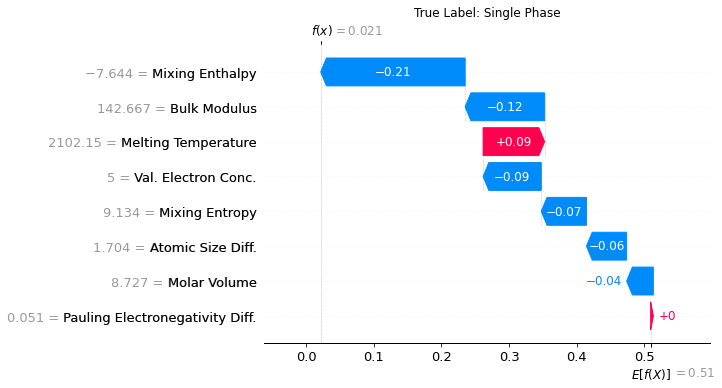

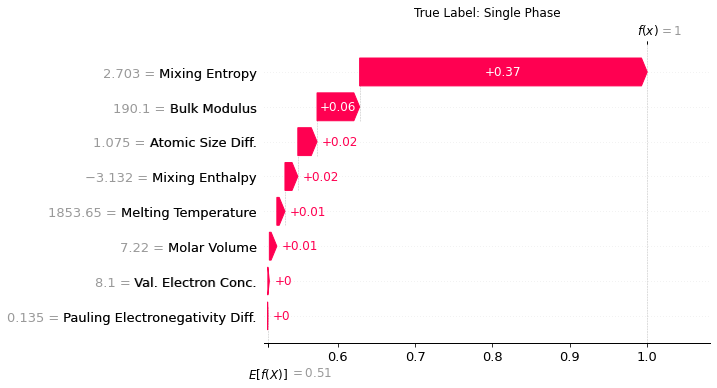

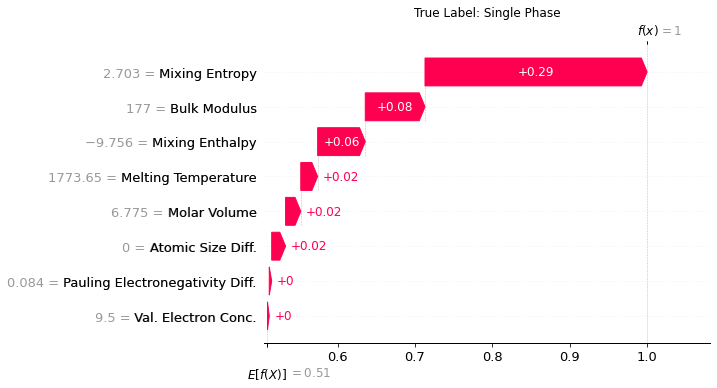

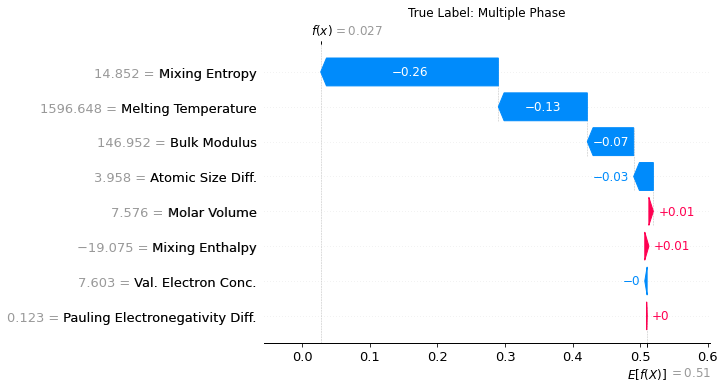

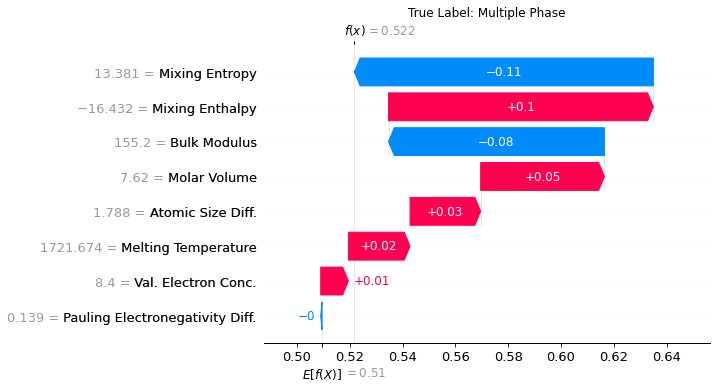

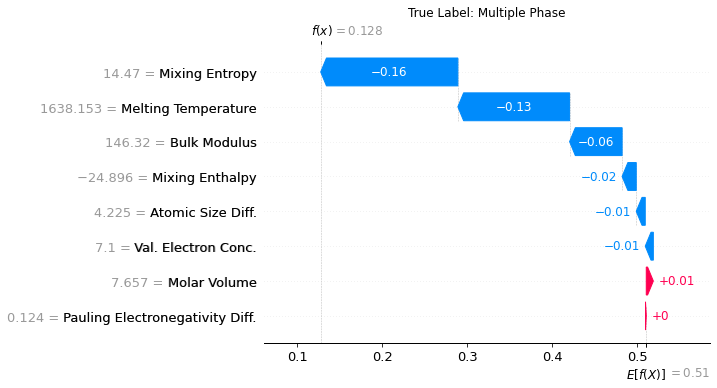

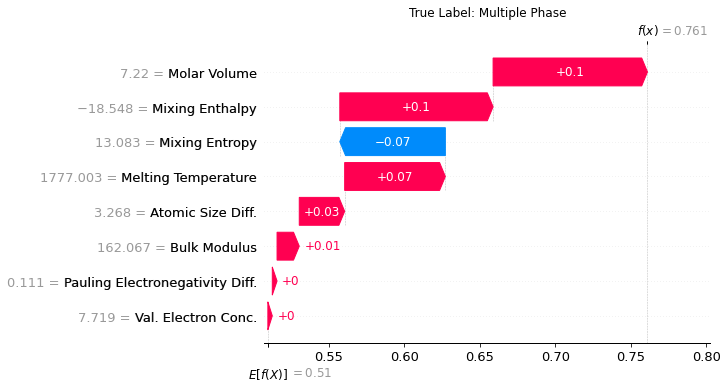

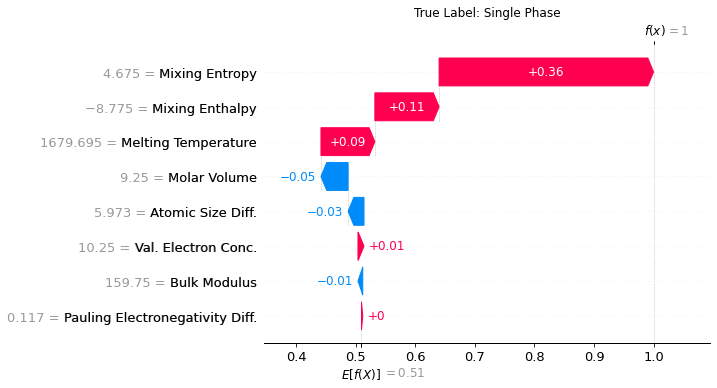

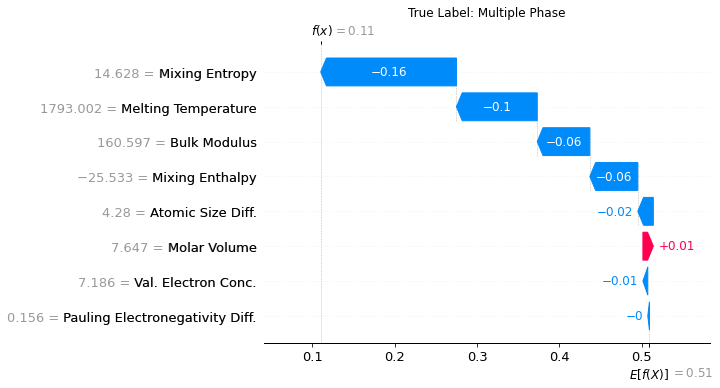

In [24]:
for i in range(len(shap_values[0])):
    exp = shap.Explanation(shap_values[0][i], explainer.expected_value[0], data=np.array(test_hea.loc[:, "k":"delta_h_mix"].values[i]),
                                                                                      feature_names=feature_names)
    shap.plots.waterfall(exp, show=False)
    y = np.array(test_hea.loc[:, "Class"].values[i])
    if y == 1:
        plt.title('True Label: Single Phase')
    elif y == 0:
        plt.title('True Label: Multiple Phase')
#     plt.savefig("/Test_SHAP_"  + str(i) + ".pdf", dpi=200)
    plt.show()
    plt.close()

In [25]:
%matplotlib inline
shap.initjs()

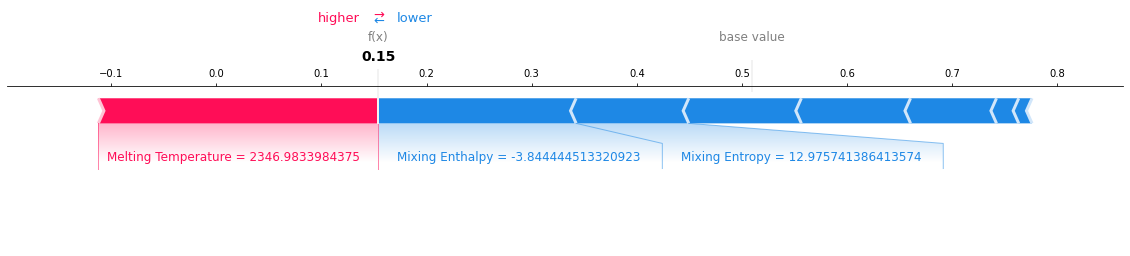

In [26]:
shap.plots.force(explainer.expected_value, shap_values[0][1], features=np.array(test_hea.loc[:, "k":"delta_h_mix"].values[1], np.float32), 
                     feature_names=feature_names, matplotlib=True)

**This plot is the above plot for all test points rotated and stacked, it's interactive**

In [27]:
shap.plots.force(explainer.expected_value, shap_values[0], features=np.array(test_hea.loc[:, "k":"delta_h_mix"].values, np.float32), 
                 feature_names=feature_names)